#### from pathlib import Path

candidates = list(Path(".").rglob("*matched*argo*bgc*profiles*bbp*.csv"))
for p in candidates[:10]:
    print(p)

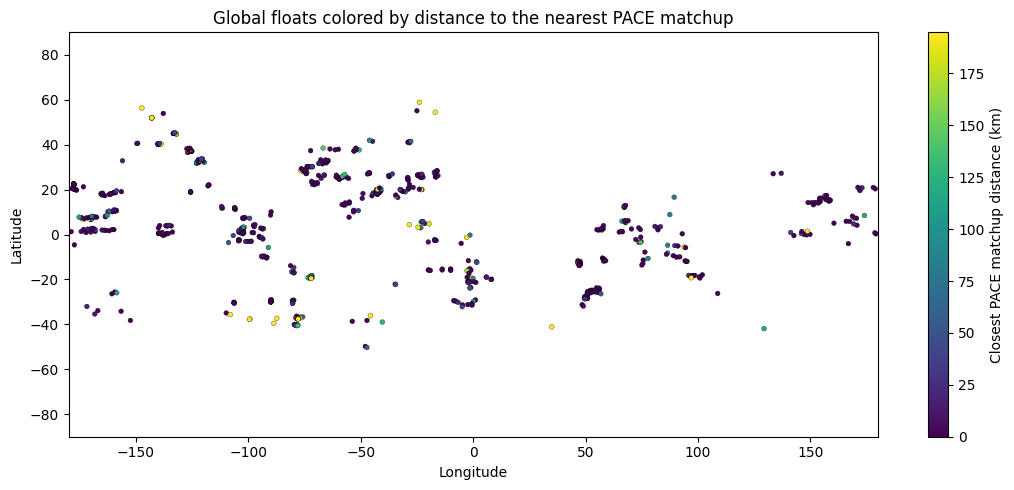

In [4]:
# === CONFIG ===
CSV_IN   = "/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_argo_bgc_profiles_bbp.csv"
CSV_OUT  = "float_min_distance.csv"
PNG_OUT  = "global_float_distance.png"
CMAP     = "viridis"
POINT_SZ = 12
ROBUST_P = 95

import pandas as pd, numpy as np, matplotlib.pyplot as plt, re, os
from pathlib import Path

assert Path(CSV_IN).exists(), f"File not found: {CSV_IN}"

# --- Load & normalize column names ---
df = pd.read_csv(CSV_IN)
df.columns = [c.strip() for c in df.columns]
lower = {c: re.sub(r"\s+", "_", c.strip().lower()) for c in df.columns}
df.rename(columns=lower, inplace=True)

def pick(cols, pats):
    for p in pats:
        for c in cols:
            if re.search(p, c):
                return c
    return None

cols = df.columns.tolist()

# Float coords & ID
float_lat = pick(cols, [r"^float_?lat$", r"^argo_?lat$", r"^profile_?lat$", r"^lat_?float$", r"^lat$"])
float_lon = pick(cols, [r"^float_?lon$", r"^argo_?lon$", r"^profile_?lon$", r"^lon_?float$", r"^lon$"])
float_id  = pick(cols, [r"^wmo$", r"platform(_number)?$", r"^float_id$", r"^argo_id$"])

# PACE coords (only used if no distance column)
pace_lat  = pick(cols, [r"^pace_?lat$", r"^match_?lat$", r"^sat_?lat$", r"^oci_?lat$", r"^granule_?lat$", r"^l2_?lat$"])
pace_lon  = pick(cols, [r"^pace_?lon$", r"^match_?lon$", r"^sat_?lon$", r"^oci_?lon$", r"^granule_?lon$", r"^l2_?lon$"])

# Precomputed distance?
dist_col = pick(cols, [r"(distance|dist|separation).*km$", r"^(distance|dist|separation)$"])

# --- Compute great-circle distance (km) if needed ---
def haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 6371.0 * (2*np.arcsin(np.sqrt(a)))

if dist_col is None:
    if not (float_lat and float_lon and pace_lat and pace_lon):
        raise ValueError
    def norm_lon(x): return ((np.asarray(x, float) + 180) % 360) - 180
    flon = norm_lon(df[float_lon])
    plon = norm_lon(df[pace_lon])
    flat = df[float_lat].astype(float)
    plat = df[pace_lat].astype(float)
    df["distance_km"] = haversine_km(flat, flon, plat, plon)
    dist_col = "distance_km"

# --- Per-float key (prefer WMO/ID, else rounded lat/lon) ---
if float_id:
    df["_float_key"] = df[float_id].astype(str)
else:
    if not (float_lat and float_lon):
        raise ValueError
    df["_float_key"] = (df[float_lat].astype(float).round(2).astype(str) + "," +
                        df[float_lon].astype(float).round(2).astype(str))

# --- Reduce to one row per float: min distance + median location ---
agg = (df.groupby("_float_key")
         .agg(lat=(float_lat, "median"),
              lon=(float_lon, "median"),
              min_distance_km=(dist_col, "min"))
         .reset_index(drop=True))

# Normalize lon to [-180, 180]
agg["lon"] = ((agg["lon"] + 180) % 360) - 180

# --- Color scale robust to outliers ---
v = np.nanpercentile(agg["min_distance_km"], ROBUST_P)
vmax = float(v) if np.isfinite(v) and v > 0 else float(agg["min_distance_km"].max() or 1.0)

# --- Plot ---
plt.figure(figsize=(11,5))
sc = plt.scatter(agg["lon"], agg["lat"],
                 c=agg["min_distance_km"], s=POINT_SZ,
                 cmap=CMAP, vmin=0, vmax=vmax,
                 edgecolors="k", linewidths=0.2)
plt.xlim(-180, 180); plt.ylim(-90, 90)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
cb = plt.colorbar(sc); cb.set_label("Closest PACE matchup distance (km)")
plt.title("Global floats colored by distance to the nearest PACE matchup")
plt.tight_layout()
plt.savefig(PNG_OUT, dpi=200)
plt.show()

/opt/anaconda3/envs/earthaccess-env/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


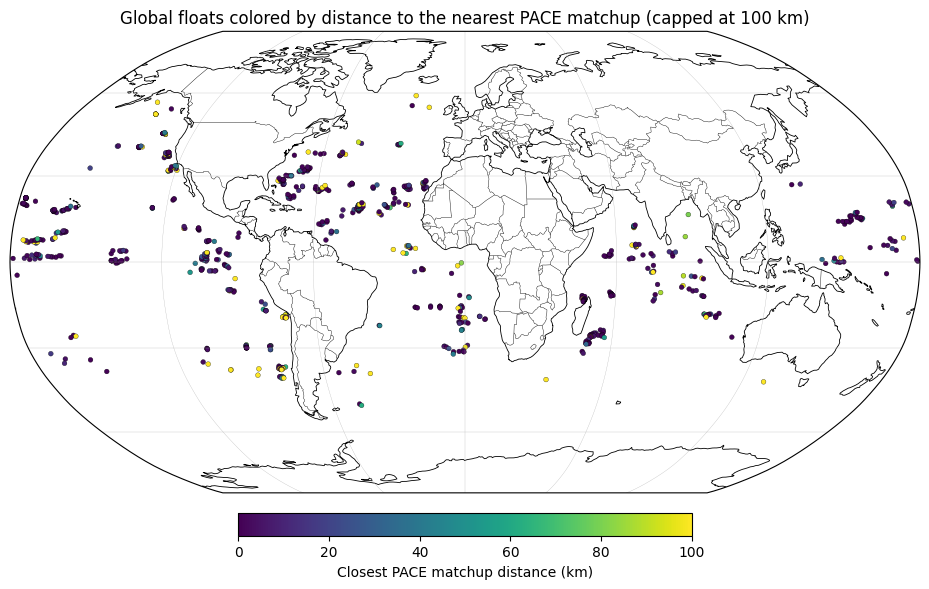

In [6]:
# === CONFIG ===
CSV_IN   = "/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_argo_bgc_profiles_bbp.csv"
CSV_OUT  = "float_min_distance.csv"          # per-float table to save
PNG_OUT  = "global_float_distance.png"       # map image to save
CMAP     = "viridis"
POINT_SZ = 12
VMIN, VMAX = 0.0, 100.0                      # <-- cap at 0..100 km

import pandas as pd, numpy as np, matplotlib.pyplot as plt, re

# --- Load & normalize column names ---
df = pd.read_csv(CSV_IN)
df.columns = [c.strip() for c in df.columns]
lower = {c: re.sub(r"\s+", "_", c.strip().lower()) for c in df.columns}
df.rename(columns=lower, inplace=True)

def pick(cols, pats):
    for p in pats:
        for c in cols:
            if re.search(p, c):
                return c
    return None

cols = df.columns.tolist()

# Float coords & ID
float_lat = pick(cols, [r"^float_?lat$", r"^argo_?lat$", r"^profile_?lat$", r"^lat_?float$", r"^lat$"])
float_lon = pick(cols, [r"^float_?lon$", r"^argo_?lon$", r"^profile_?lon$", r"^lon_?float$", r"^lon$"])
float_id  = pick(cols, [r"^wmo$", r"platform(_number)?$", r"^float_id$", r"^argo_id$"])

# PACE coords (only used if no distance column)
pace_lat  = pick(cols, [r"^pace_?lat$", r"^match_?lat$", r"^sat_?lat$", r"^oci_?lat$", r"^granule_?lat$", r"^l2_?lat$"])
pace_lon  = pick(cols, [r"^pace_?lon$", r"^match_?lon$", r"^sat_?lon$", r"^oci_?lon$", r"^granule_?lon$", r"^l2_?lon$"])

# Precomputed distance?
dist_col = pick(cols, [r"(distance|dist|separation).*km$", r"^(distance|dist|separation)$"])

# --- Compute great-circle distance (km) if needed ---
def haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 6371.0 * (2*np.arcsin(np.sqrt(a)))  # Earth radius 6371 km

if dist_col is None:
    if not (float_lat and float_lon and pace_lat and pace_lon):
        raise ValueError("Couldn't find enough columns to compute distance. "
                         "Need float & PACE lat/lon OR an existing distance column.")
    def norm_lon(x): return ((np.asarray(x, float) + 180) % 360) - 180
    df["distance_km"] = haversine_km(df[float_lat].astype(float),
                                     norm_lon(df[float_lon]),
                                     df[pace_lat].astype(float),
                                     norm_lon(df[pace_lon]))
    dist_col = "distance_km"

# --- Per-float key (prefer WMO/ID, else rounded lat/lon) ---
if float_id:
    df["_float_key"] = df[float_id].astype(str)
else:
    if not (float_lat and float_lon):
        raise ValueError("Missing float coordinates for fallback grouping.")
    df["_float_key"] = (df[float_lat].astype(float).round(2).astype(str) + "," +
                        df[float_lon].astype(float).round(2).astype(str))

# --- Reduce to one row per float: min distance + median location ---
agg = (df.groupby("_float_key")
         .agg(lat=(float_lat, "median"),
              lon=(float_lon, "median"),
              min_distance_km=(dist_col, "min"))
         .reset_index(drop=True))

# Normalize lon for plotting
agg["lon"] = ((agg["lon"] + 180) % 360) - 180

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.coastlines(linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.gridlines(draw_labels=False, linewidth=0.2)

    sc = ax.scatter(agg["lon"], agg["lat"],
                    c=agg["min_distance_km"], s=POINT_SZ,
                    cmap=CMAP, vmin=VMIN, vmax=VMAX,
                    transform=ccrs.PlateCarree(),
                    edgecolors="k", linewidths=0.2)

    cb = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.04, fraction=0.045)
    cb.set_label("Closest PACE matchup distance (km)")
    plt.title("Global floats colored by distance to the nearest PACE matchup (capped at 100 km)")
    plt.tight_layout()
    plt.savefig(PNG_OUT, dpi=200)
    plt.show()

except Exception as e:
    print("(Cartopy not available; plotting without coastlines)\nReason:", e)
    plt.figure(figsize=(11,5))
    sc = plt.scatter(agg["lon"], agg["lat"],
                     c=agg["min_distance_km"], s=POINT_SZ,
                     cmap=CMAP, vmin=VMIN, vmax=VMAX,
                     edgecolors="k", linewidths=0.2)
    plt.xlim(-180, 180); plt.ylim(-90, 90)
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    cb = plt.colorbar(sc); cb.set_label("Closest PACE matchup distance (km)")
    plt.title("Global floats colored by distance to the nearest PACE matchup (capped at 100 km)")
    plt.tight_layout()
    plt.savefig(PNG_OUT, dpi=200)
    plt.show()

In [7]:
import pandas as pd
import numpy as np
import re

CSV_IN = "/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_argo_bgc_profiles_bbp.csv"

df = pd.read_csv(CSV_IN)
cols = {c.lower().strip().replace(" ", "_"): c for c in df.columns}

def pick(*pats):
    for p in pats:
        for k in cols:
            if re.search(p, k):
                return cols[k]
    return None

# Use a precomputed distance column if present; otherwise compute from float↔PACE coords like before
dist_c = pick(r"(distance|dist|separation).*km$", r"^(distance|dist|separation)$")
if dist_c is None:
    # try to compute distances
    lat_f  = pick(r"^float_?lat$", r"^argo_?lat$", r"^profile_?lat$", r"\b(lat|latitude)\b")
    lon_f  = pick(r"^float_?lon$", r"^argo_?lon$", r"^profile_?lon$", r"\b(lon|longitude)\b")
    lat_p  = pick(r"^pace_?lat$", r"^match_?lat$", r"^sat_?lat$", r"^oci_?lat$", r"^l2_?lat$")
    lon_p  = pick(r"^pace_?lon$", r"^match_?lon$", r"^sat_?lon$", r"^oci_?lon$", r"^l2_?lon$")
    if not all([lat_f, lon_f, lat_p, lon_p]):
        raise ValueError("Need a distance column or float & PACE lat/lon to compute distances.")
    def norm(x): return ((np.asarray(x, float) + 180) % 360) - 180
    def haversine_km(a1, b1, a2, b2):
        a1, b1, a2, b2 = map(np.radians, [a1, b1, a2, b2])
        dlon, dlat = b2 - b1, a2 - a1
        h = np.sin(dlat/2)**2 + np.cos(a1)*np.cos(a2)*np.sin(dlon/2)**2
        return 6371.0 * (2*np.arcsin(np.sqrt(h)))
    df["distance_km"] = haversine_km(df[lat_f], norm(df[lon_f]), df[lat_p], norm(df[lon_p]))
    dist_c = "distance_km"

d = df[dist_c].astype(float).dropna().values

# Summary stats that answer “where the majority are”
p25, p50, p75 = np.percentile(d, [25, 50, 75])
p90 = np.percentile(d, 90)
under_25  = np.mean(d <= 25)  * 100
under_50  = np.mean(d <= 50)  * 100
under_100 = np.mean(d <= 100) * 100

print(f"Total matchups: {d.size}")
print(f"Median (50th pct): {p50:.1f} km")
print(f"IQR (25th–75th): {p25:.1f}–{p75:.1f} km")
print(f"90th percentile: {p90:.1f} km")
print(f"≤ 25 km:  {under_25:5.1f}% of matchups")
print(f"≤ 50 km:  {under_50:5.1f}% of matchups")
print(f"≤ 100 km: {under_100:5.1f}% of matchups")

Total matchups: 812
Median (50th pct): 2.1 km
IQR (25th–75th): 0.6–19.4 km
90th percentile: 100.4 km
≤ 25 km:   78.1% of matchups
≤ 50 km:   84.4% of matchups
≤ 100 km:  89.9% of matchups


In [8]:
bins = np.arange(0, max(100, d.max()) + 10, 10)
hist, edges = np.histogram(d, bins=bins)
imax = hist.argmax()
print(f"Most populated bin: {edges[imax]:.0f}–{edges[imax+1]:.0f} km "
      f"({hist[imax]} matchups, {100*hist[imax]/d.size:.1f}%)")

Most populated bin: 0–10 km (565 matchups, 69.6%)


In [10]:
from pathlib import Path

candidates = list(Path(".").rglob("*argo*bgc*profiles*bbp*.csv"))
for p in candidates[:10]:
    print(p)

Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_argo_bgc_profiles_bbp.csv
Documents/summer 2025/python/bing/papers/biomass/Analysis/argo_bgc_profiles_bbp.csv


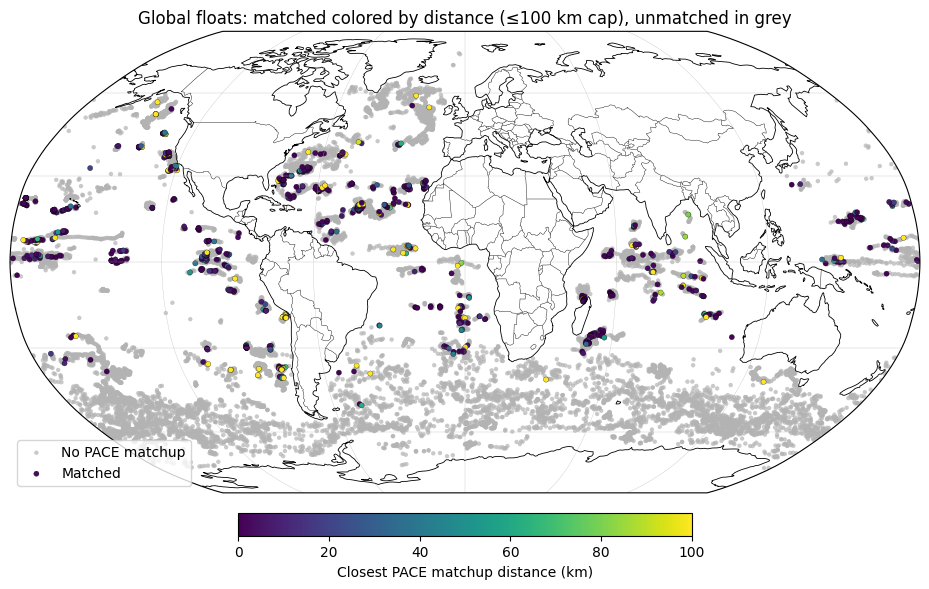

Matched floats plotted:  786
Unmatched floats plotted: 15716


In [11]:
# --- INPUTS: set your two files ---
CSV_MATCHED = "/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_argo_bgc_profiles_bbp.csv"
CSV_ALL     = "/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/argo_bgc_profiles_bbp.csv"

# --- CONFIG ---
CAP_KM   = 100.0      # cap color scale at 0..100 km
CMAP     = "viridis"  # colormap for matched points
DOT_ALL  = 10         # size of grey "all floats"
DOT_MATCH= 14         # size of colored "matched (min dist)"

import pandas as pd, numpy as np, matplotlib.pyplot as plt, re

def read_and_normalize(path):
    df = pd.read_csv(path)
    norm = {c: re.sub(r"\s+","_",c.strip().lower()) for c in df.columns}
    df.rename(columns=norm, inplace=True)
    return df

def pick(df, *pats):
    cols = df.columns
    for pat in pats:
        rgx = re.compile(pat, re.I)
        for c in cols:
            if rgx.search(c): return c
    return None

def norm_lon(x): return ((np.asarray(x, float) + 180) % 360) - 180

# --- load full float table (ALL) ---
all_df = read_and_normalize(CSV_ALL)
lat_all = pick(all_df, r"^float_?lat$", r"^argo_?lat$", r"^profile_?lat$", r"(^|_)lat(itude)?$")
lon_all = pick(all_df, r"^float_?lon$", r"^argo_?lon$", r"^profile_?lon$", r"(^|_)lon(gitude)?$")
id_all  = pick(all_df, r"^wmo$", r"platform(_number)?$", r"^float_id$", r"^argo_id$")

if id_all:
    all_per_float = (all_df
                     .groupby(id_all)
                     .agg(lat=(lat_all,"median"), lon=(lon_all,"median"))
                     .reset_index())
else:
    # fallback: group by rounded lat/lon (≈0.02°)
    all_df["_key"] = all_df[lat_all].round(2).astype(str)+","+all_df[lon_all].round(2).astype(str)
    all_per_float = (all_df.groupby("_key")
                     .agg(lat=(lat_all,"median"), lon=(lon_all,"median"))
                     .reset_index(drop=True))

all_per_float["lon"] = norm_lon(all_per_float["lon"])

# --- load matched table (MATCHED) and reduce per float with min distance ---
m = read_and_normalize(CSV_MATCHED)
lat_m = pick(m, r"^float_?lat$", r"^argo_?lat$", r"^profile_?lat$", r"(^|_)lat(itude)?$")
lon_m = pick(m, r"^float_?lon$", r"^argo_?lon$", r"^profile_?lon$", r"(^|_)lon(gitude)?$")
id_m  = pick(m, r"^wmo$", r"platform(_number)?$", r"^float_id$", r"^argo_id$")
dist  = pick(m, r"(distance|dist|separation).*km$", r"^(distance|dist|separation)_?km$", r"^(distance|dist|separation)$")
if dist is None:
    raise ValueError("Couldn't find a distance column (km) in the matched CSV.")

if id_m:
    matched_per_float = (m.groupby(id_m)
                           .agg(lat=(lat_m,"median"),
                                lon=(lon_m,"median"),
                                min_distance_km=(dist,"min"))
                           .reset_index())
    # figure out which floats are unmatched (present in ALL but not in MATCHED)
    matched_ids = set(matched_per_float[id_m].astype(str))
    all_per_float["_id"] = (all_df[id_all].astype(str).drop_duplicates().values
                            if id_all else np.arange(len(all_per_float)))
    # if we had IDs in ALL, use them; otherwise we’ll mark unmatched by spatial set diff later
else:
    # no IDs → define per-float key by rounded lat/lon to identify matched set
    m["_key"] = m[lat_m].round(2).astype(str)+","+m[lon_m].round(2).astype(str)
    matched_per_float = (m.groupby("_key")
                           .agg(lat=(lat_m,"median"),
                                lon=(lon_m,"median"),
                                min_distance_km=(dist,"min"))
                           .reset_index())
    all_per_float["_key"] = all_per_float["lat"].round(2).astype(str)+","+all_per_float["lon"].round(2).astype(str)

matched_per_float["lon"] = norm_lon(matched_per_float["lon"])

# --- compute unmatched floats (present in ALL but not in MATCHED) ---
if id_m and id_all:
    all_ids = set(all_df[id_all].astype(str).unique())
    unmatched_ids = list(all_ids - matched_ids)
    # build positions for unmatched (median per float)
    unmatched = (all_df[all_df[id_all].astype(str).isin(unmatched_ids)]
                 .groupby(id_all)
                 .agg(lat=(lat_all,"median"), lon=(lon_all,"median"))
                 .reset_index())
    unmatched["lon"] = norm_lon(unmatched["lon"])
else:
    # key-based fallback
    matched_keys = set(matched_per_float.get("_key", 
                     (matched_per_float["lat"].round(2).astype(str)+","+matched_per_float["lon"].round(2).astype(str))).values)
    all_keys = set(all_per_float.get("_key",
                 (all_per_float["lat"].round(2).astype(str)+","+all_per_float["lon"].round(2).astype(str))).values)
    diff_keys = list(all_keys - matched_keys)
    mask = all_per_float.get("_key",
           (all_per_float["lat"].round(2).astype(str)+","+all_per_float["lon"].round(2).astype(str))).isin(diff_keys)
    unmatched = all_per_float.loc[mask, ["lat","lon"]].copy()

# --- PLOT: grey unmatched under colored matched (capped at 100 km) ---
VMIN, VMAX = 0.0, CAP_KM

try:
    import cartopy.crs as ccrs, cartopy.feature as cfeature
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global(); ax.coastlines(linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.gridlines(draw_labels=False, linewidth=0.2)

    # draw unmatched first (grey)
    ax.scatter(unmatched["lon"], unmatched["lat"], s=DOT_ALL, c="0.7",
               transform=ccrs.PlateCarree(), edgecolors="none", alpha=0.7, label="No PACE matchup")

    # draw matched on top (colored by distance)
    sc = ax.scatter(matched_per_float["lon"], matched_per_float["lat"],
                    c=np.clip(matched_per_float["min_distance_km"].astype(float), VMIN, VMAX),
                    s=DOT_MATCH, cmap=CMAP, vmin=VMIN, vmax=VMAX,
                    transform=ccrs.PlateCarree(), edgecolors="k", linewidths=0.2, label="Matched")

    cb = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.04, fraction=0.045)
    cb.set_label("Closest PACE matchup distance (km)")

    plt.title("Global floats: matched colored by distance (≤100 km cap), unmatched in grey")
    plt.legend(loc="lower left")
    plt.tight_layout(); plt.show()

except Exception as e:
    print("(Cartopy not available; simple scatter without coastlines)\nReason:", e)
    plt.figure(figsize=(11,5))
    plt.scatter(unmatched["lon"], unmatched["lat"], s=DOT_ALL, c="0.7", edgecolors="none", alpha=0.7, label="No PACE matchup")
    sc = plt.scatter(matched_per_float["lon"], matched_per_float["lat"],
                     c=np.clip(matched_per_float["min_distance_km"].astype(float), VMIN, VMAX),
                     s=DOT_MATCH, cmap=CMAP, vmin=VMIN, vmax=VMAX, edgecolors="k", linewidths=0.2, label="Matched")
    plt.xlim(-180, 180); plt.ylim(-90, 90)
    cb = plt.colorbar(sc); cb.set_label("Closest PACE matchup distance (km)")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.title("Global floats: matched colored by distance (≤100 km cap), unmatched in grey")
    plt.legend(loc="lower left")
    plt.tight_layout(); plt.show()

print(f"Matched floats plotted:  {len(matched_per_float)}")
print(f"Unmatched floats plotted: {len(unmatched)}")

Plottable matchups: 584   Δbbp color range: ±4.229e-03 (PACE − Argo)
Saved merged table → /Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_with_argo_bbp_delta.csv


/opt/anaconda3/envs/earthaccess-env/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


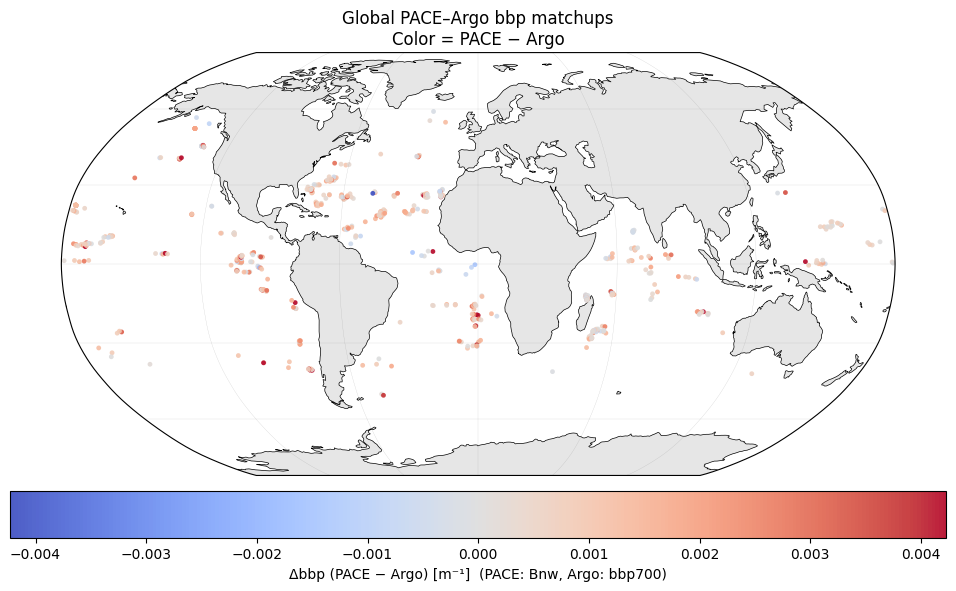

In [2]:
from pathlib import Path
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# -------- paths (edit if needed) --------
ROOT = Path.home() / "Documents" / "summer 2025" / "python" / "bing" / "papers" / "biomass" / "Analysis"
CSV_MATCHED = ROOT / "matched_argo_bgc_profiles_bbp.csv"              # has PACE 'Bnw' + cruise/profile + lat/lon
CSV_ARGO    = ROOT / "argo_bbp700_surface_mean3_from_matched.csv"     # your Argo bbp per WMO-cycle

# -------- load & normalize column names --------
m = pd.read_csv(CSV_MATCHED)
a = pd.read_csv(CSV_ARGO)
m.columns = [re.sub(r"\s+","_", c.strip().lower()) for c in m.columns]
a.columns = [re.sub(r"\s+","_", c.strip().lower()) for c in a.columns]

# --- explicit PACE column ---
PACE_BBP_COL = "bnw"   # <- your PACE bbp column name (lower-cased)
if PACE_BBP_COL not in m.columns:
    raise KeyError(f"'{PACE_BBP_COL}' not found in matched CSV. Got: {m.columns.tolist()}")

# --- required keys & subset helpful columns ---
if not {"cruise","profile"}.issubset(m.columns):
    raise KeyError("Matched CSV must have 'cruise' (WMO) and 'profile' (cycle).")
if not {"wmo","cycle","bbp700_surface_mean3"}.issubset(a.columns):
    raise KeyError("Argo CSV must have 'wmo','cycle','bbp700_surface_mean3'.")

m2 = m[["cruise","profile", PACE_BBP_COL, "lat","lon"]].copy()
m2["cruise"]  = m2["cruise"].astype(int)
m2["profile"] = m2["profile"].astype(int)

a2 = a[["wmo","cycle","bbp700_surface_mean3","lat","lon"]].copy()
a2["wmo"]   = a2["wmo"].astype(int)
a2["cycle"] = a2["cycle"].astype(int)

# --- join on WMO/cycle ---
mm = (m2.rename(columns={"cruise":"wmo","profile":"cycle"})
         .merge(a2, on=["wmo","cycle"], how="inner", suffixes=("_pace","_argo")))

# --- choose coordinates: prefer matched (PACE) lat/lon, fallback to Argo if missing ---
lat = pd.to_numeric(mm["lat_pace"].fillna(mm["lat_argo"]), errors="coerce")
lon = pd.to_numeric(mm["lon_pace"].fillna(mm["lon_argo"]), errors="coerce")

pace_bbp = pd.to_numeric(mm[PACE_BBP_COL], errors="coerce")          # PACE bnw
argo_bbp = pd.to_numeric(mm["bbp700_surface_mean3"], errors="coerce") # Argo bbp700

mm = (mm.assign(_lat=lat, _lon=lon, delta_bbp=pace_bbp - argo_bbp)
        .dropna(subset=["_lat","_lon","delta_bbp"])
        .reset_index(drop=True))

# wrap lon to [-180,180] for nice plotting
mm["_lon"] = ((mm["_lon"] + 180) % 360) - 180
delta = mm["delta_bbp"].to_numpy()

# robust symmetric color limit around 0
p = np.nanpercentile(delta, [2.5, 97.5])
L = float(max(abs(p[0]), abs(p[1])))
if not np.isfinite(L) or L == 0:
    L = float(np.nanmax(np.abs(delta))) or 1e-6

print(f"Plottable matchups: {len(mm)}   Δbbp color range: ±{L:.3e} (PACE − Argo)")

# --- save merged table for later use ---
OUT_MERGED = ROOT / "matched_with_argo_bbp_delta.csv"
(mm[["wmo","cycle","_lat","_lon", PACE_BBP_COL,"bbp700_surface_mean3","delta_bbp"]]
 .rename(columns={"_lat":"lat","_lon":"lon"})
 .to_csv(OUT_MERGED, index=False))
print(f"Saved merged table → {OUT_MERGED}")

# --- plot ---
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.add_feature(cfeature.LAND, facecolor="0.9", edgecolor="none", zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    ax.gridlines(draw_labels=False, linewidth=0.2, color="gray", alpha=0.4)

    sc = ax.scatter(mm["_lon"], mm["_lat"], c=mm["delta_bbp"], s=12,
                    cmap="coolwarm", vmin=-L, vmax=L,
                    transform=ccrs.PlateCarree(), linewidths=0, alpha=0.9)

    cb = plt.colorbar(sc, orientation="horizontal", pad=0.03, shrink=0.8)
    cb.set_label("Δbbp (PACE − Argo) [m⁻¹]  (PACE: Bnw, Argo: bbp700)")

    ax.set_title("Global PACE–Argo bbp matchups\nColor = PACE − Argo", fontsize=12)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Cartopy plot failed ({e}); using simple lon/lat scatter instead.")
    plt.figure(figsize=(10,5))
    plt.scatter(mm["_lon"], mm["_lat"], c=mm["delta_bbp"], s=12,
                cmap="coolwarm", vmin=-L, vmax=L)
    plt.colorbar(label="Δbbp (PACE − Argo) [m⁻¹]")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.title("PACE–Argo bbp matchups (simple)")
    plt.tight_layout()
    plt.show()

In [3]:
from pathlib import Path
import re, numpy as np, pandas as pd

ROOT = Path.home() / "Documents" / "summer 2025" / "python" / "bing" / "papers" / "biomass" / "Analysis"
CSV_MATCHED = ROOT / "matched_argo_bgc_profiles_bbp.csv"              # has PACE 'Bnw' + cruise/profile + lat/lon
CSV_ARGO    = ROOT / "argo_bbp700_surface_mean3_from_matched.csv"     # Argo bbp per WMO-cycle

# Load & normalize
m = pd.read_csv(CSV_MATCHED)
a = pd.read_csv(CSV_ARGO)
m.columns = [re.sub(r"\s+","_", c.strip().lower()) for c in m.columns]
a.columns = [re.sub(r"\s+","_", c.strip().lower()) for c in a.columns]

PACE_BBP_COL = "bnw"  # PACE column
assert {"cruise","profile",PACE_BBP_COL}.issubset(m.columns)
assert {"wmo","cycle","bbp700_surface_mean3"}.issubset(a.columns)

m2 = m[["cruise","profile",PACE_BBP_COL,"lat","lon"]].rename(
        columns={"cruise":"wmo","profile":"cycle","lat":"lat_pace","lon":"lon_pace"}
     ).astype({"wmo":int,"cycle":int})
a2 = a[["wmo","cycle","bbp700_surface_mean3","lat","lon"]].rename(
        columns={"lat":"lat_argo","lon":"lon_argo"}
     ).astype({"wmo":int,"cycle":int})

# Left-join so we can see what’s missing on the Argo side
L = m2.merge(a2, on=["wmo","cycle"], how="left", indicator=True)

total_pairs = len(L)
no_argo = (L["_merge"] == "left_only").sum()

# Numbers
L["pace_bbp"] = pd.to_numeric(L[PACE_BBP_COL], errors="coerce")
L["argo_bbp"] = pd.to_numeric(L["bbp700_surface_mean3"], errors="coerce")
L["lat_use"]  = pd.to_numeric(L["lat_pace"].fillna(L["lat_argo"]), errors="coerce")
L["lon_use"]  = pd.to_numeric(L["lon_pace"].fillna(L["lon_argo"]), errors="coerce")
L["delta"]    = L["pace_bbp"] - L["argo_bbp"]

missing_pace   = L["pace_bbp"].isna().sum()
missing_argo   = L["_merge"].eq("both").sum() - L["argo_bbp"].notna().sum()
missing_coords = (~np.isfinite(L["lat_use"]) | ~np.isfinite(L["lon_use"])).sum()
nan_delta      = (~np.isfinite(L["delta"])).sum()

kept = L["_merge"].eq("both") & np.isfinite(L["pace_bbp"]) & np.isfinite(L["argo_bbp"]) \
       & np.isfinite(L["lat_use"]) & np.isfinite(L["lon_use"]) & np.isfinite(L["delta"])
kept_n = kept.sum()

print(f"Total matched rows (WMO–cycle) : {total_pairs}")
print(f"  Missing Argo row after join  : {no_argo}")
print(f"  PACE bnw missing/non-numeric : {missing_pace}")
print(f"  Argo bbp missing/non-numeric : {missing_argo}")
print(f"  Missing coordinates          : {missing_coords}")
print(f"  Δbbp not finite (NaN/inf)    : {nan_delta}")
print(f"  -------------------------------")
print(f"  Kept and plotted             : {kept_n}")

# Optional: peek at a few examples of each category
def peek(msg, cond, n=5):
    ex = L.loc[cond, ["wmo","cycle",PACE_BBP_COL,"bbp700_surface_mean3","lat_pace","lon_pace","lat_argo","lon_argo"]].head(n)
    if len(ex): 
        print(f"\n{msg} (showing {len(ex)} of {(cond).sum()}):")
        display(ex)

peek("No Argo row", L["_merge"]=="left_only")
peek("PACE bnw missing", L["pace_bbp"].isna())
peek("Argo bbp missing", L["_merge"].eq("both") & L["argo_bbp"].isna())
peek("Coords missing", ~np.isfinite(L["lat_use"]) | ~np.isfinite(L["lon_use"]))
peek("Δbbp NaN/inf", ~np.isfinite(L["delta"]))

Total matched rows (WMO–cycle) : 812
  Missing Argo row after join  : 170
  PACE bnw missing/non-numeric : 1
  Argo bbp missing/non-numeric : 57
  Missing coordinates          : 0
  Δbbp not finite (NaN/inf)    : 228
  -------------------------------
  Kept and plotted             : 584

No Argo row (showing 5 of 170):


,wmo,cycle,bnw,bbp700_surface_mean3,lat_pace,lon_pace,lat_argo,lon_argo
11,1902370,34,0.001014,NaN,5.828,167.535,NaN,NaN
12,1902371,0,0.003244,NaN,51.955,-142.958,NaN,NaN
21,1902372,13,0.002407,NaN,0.350,93.043,NaN,NaN
35,1902381,81,0.001792,NaN,16.511,-33.530,NaN,NaN
36,1902381,94,0.000005,NaN,17.077,-34.417,NaN,NaN



PACE bnw missing (showing 1 of 1):


,wmo,cycle,bnw,bbp700_surface_mean3,lat_pace,lon_pace,lat_argo,lon_argo
798,7902111,51,NaN,0.000752,40.284,-138.726,40.2464,-138.7228



Argo bbp missing (showing 5 of 57):


,wmo,cycle,bnw,bbp700_surface_mean3,lat_pace,lon_pace,lat_argo,lon_argo
9,1902370,16,0.000808,NaN,5.055,160.529,4.93024,160.17283
10,1902370,28,0.001182,NaN,5.898,165.981,5.53331,162.21414
140,1902497,41,0.001253,NaN,-11.625,-2.123,-11.89410,-1.84730
260,2903829,7,0.001380,NaN,8.897,87.493,8.91218,87.48107
261,2903831,9,0.001087,NaN,16.614,89.456,16.50974,89.67987



Δbbp NaN/inf (showing 5 of 228):


,wmo,cycle,bnw,bbp700_surface_mean3,lat_pace,lon_pace,lat_argo,lon_argo
9,1902370,16,0.000808,NaN,5.055,160.529,4.93024,160.17283
10,1902370,28,0.001182,NaN,5.898,165.981,5.53331,162.21414
11,1902370,34,0.001014,NaN,5.828,167.535,NaN,NaN
12,1902371,0,0.003244,NaN,51.955,-142.958,NaN,NaN
21,1902372,13,0.002407,NaN,0.350,93.043,NaN,NaN


In [4]:
import numpy as np, pandas as pd
from pathlib import Path

# Path to the merged table we wrote earlier
CSV = Path.home() / "Documents" / "summer 2025" / "python" / "bing" / "papers" / "biomass" / "Analysis" / "matched_with_argo_bbp_delta.csv"

df = pd.read_csv(CSV)

# If delta_bbp isn't present, compute it from columns in the merged file
if "delta_bbp" not in df.columns:
    # adjust these names if yours differ
    pace = pd.to_numeric(df.get("bnw"), errors="coerce")
    argo = pd.to_numeric(df.get("bbp700_surface_mean3"), errors="coerce")
    df["delta_bbp"] = pace - argo

d  = pd.to_numeric(df["delta_bbp"], errors="coerce").to_numpy()
d  = d[np.isfinite(d)]
da = np.abs(d)

def pct(x): return 100 * x

p25, p50, p75, p90 = np.percentile(d,  [25, 50, 75, 90])
a25,a50,a75,a90    = np.percentile(da, [25, 50, 75, 90])

# Choose practical thresholds for |Δbbp| (m^-1); tweak if you like
thr = [1e-3, 2e-3, 5e-3]

print("Δbbp = PACE − Argo (m⁻¹)")
print(f"Median (50th pct): {p50: .3e}")
print(f"IQR (25th–75th):  {p25: .3e} – {p75: .3e}")
print(f"90th percentile:  {p90: .3e}")
print(f"n = {d.size} matchups (finite)\n")

print("|Δbbp| (m⁻¹)")
print(f"Median (50th pct): {a50: .3e}")
print(f"IQR (25th–75th):  {a25: .3e} – {a75: .3e}")
print(f"90th percentile:  {a90: .3e}")
for t in thr:
    print(f"≤ {t: .1e}: {pct(np.mean(da <= t)):.1f}% of matchups")

Δbbp = PACE − Argo (m⁻¹)
Median (50th pct):  6.817e-04
IQR (25th–75th):   1.967e-04 –  1.441e-03
90th percentile:   2.466e-03
n = 584 matchups (finite)

|Δbbp| (m⁻¹)
Median (50th pct):  7.174e-04
IQR (25th–75th):   3.209e-04 –  1.473e-03
90th percentile:   2.479e-03
≤  1.0e-03: 62.2% of matchups
≤  2.0e-03: 85.4% of matchups
≤  5.0e-03: 97.9% of matchups


Relative Δbbp = (PACE − Argo) / PACE
Median (50th pct): +0.529
IQR (25th–75th):  +0.239 – +0.697
90th percentile:  +0.810
|rel| median: 0.583   IQR: 0.386 – 0.745   90th pct: 0.850
≤  10% |rel|: 6.3% of matchups
≤  25% |rel|: 14.9% of matchups
≤  50% |rel|: 38.2% of matchups
≤ 100% |rel|: 95.9% of matchups
n = 584 matchups (finite)

Saved relative table → /Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_with_argo_bbp_relpace.csv


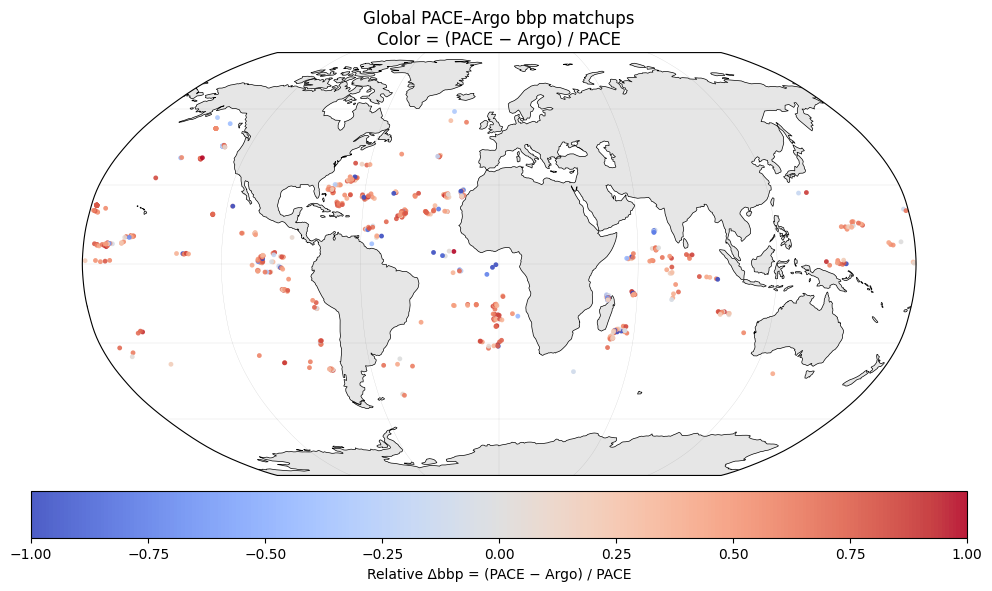

In [5]:
# === Relative difference: (PACE - Argo) / PACE ===
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

ROOT = Path.home() / "Documents" / "summer 2025" / "python" / "bing" / "papers" / "biomass" / "Analysis"
MERGED_CSV = ROOT / "matched_with_argo_bbp_delta.csv"   # from earlier step
OUT_RELCSV = ROOT / "matched_with_argo_bbp_relpace.csv"

# ---- load merged or reuse in-memory 'mm' ----
try:
    df = mm.copy()
except NameError:
    df = pd.read_csv(MERGED_CSV)

# columns (PACE=bnw, Argo=bbp700_surface_mean3)
pace = pd.to_numeric(df.get("bnw"), errors="coerce")
argo = pd.to_numeric(df.get("bbp700_surface_mean3"), errors="coerce")

# coords (prefer _lat/_lon if present from earlier code)
lat = pd.to_numeric((df["_lat"] if "_lat" in df else df.get("lat")), errors="coerce")
lon = pd.to_numeric((df["_lon"] if "_lon" in df else df.get("lon")), errors="coerce")

# ---- compute relative difference ----
rel = (pace - argo) / pace
rel = rel.replace([np.inf, -np.inf], np.nan)
df["rel_delta"] = rel

# keep finite rows & wrap lon to [-180,180]
m = np.isfinite(lat) & np.isfinite(lon) & np.isfinite(rel)
latp = lat[m].to_numpy()
lonp = (((lon[m] + 180) % 360) - 180).to_numpy()
relp = rel[m].to_numpy()

# symmetric color limits (robust) and cap at ±1 (±100%)
p = np.nanpercentile(relp, [2.5, 97.5])
L = float(max(abs(p[0]), abs(p[1])))
if not np.isfinite(L) or L == 0:
    L = 1.0
L = min(L, 1.0)  # cap to ±100%

# ---- quick stats (like before) ----
absrel = np.abs(relp)
q25, q50, q75, q90 = np.percentile(relp,  [25, 50, 75, 90])
a25, a50, a75, a90 = np.percentile(absrel, [25, 50, 75, 90])
print("Relative Δbbp = (PACE − Argo) / PACE")
print(f"Median (50th pct): {q50:+.3f}")
print(f"IQR (25th–75th):  {q25:+.3f} – {q75:+.3f}")
print(f"90th percentile:  {q90:+.3f}")
print(f"|rel| median: {a50:.3f}   IQR: {a25:.3f} – {a75:.3f}   90th pct: {a90:.3f}")
for t in (0.10, 0.25, 0.50, 1.00):
    print(f"≤ {int(t*100):>3d}% |rel|: {100*np.mean(absrel <= t):.1f}% of matchups")
print(f"n = {relp.size} matchups (finite)\n")

# ---- save a tidy CSV with relative difference ----
to_save = df.loc[m, ["wmo","cycle"] if "wmo" in df.columns else []].copy()
to_save["lat"] = latp; to_save["lon"] = lonp; to_save["rel_delta"] = relp
to_save.to_csv(OUT_RELCSV, index=False)
print(f"Saved relative table → {OUT_RELCSV}")

# ---- plot map ----
try:
    import cartopy.crs as ccrs, cartopy.feature as cfeature
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.add_feature(cfeature.LAND, facecolor="0.9", edgecolor="none", zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    ax.gridlines(draw_labels=False, linewidth=0.2, color="gray", alpha=0.4)

    sc = ax.scatter(lonp, latp, c=relp, s=12, cmap="coolwarm",
                    vmin=-L, vmax=L, transform=ccrs.PlateCarree(),
                    linewidths=0, alpha=0.9)
    cb = plt.colorbar(sc, orientation="horizontal", pad=0.03, shrink=0.8)
    cb.set_label("Relative Δbbp = (PACE − Argo) / PACE")

    ax.set_title("Global PACE–Argo bbp matchups\nColor = (PACE − Argo) / PACE", fontsize=12)
    plt.tight_layout(); plt.show()

except Exception as e:
    print(f"Cartopy plot failed ({e}); falling back to plain scatter.")
    plt.figure(figsize=(10,5))
    plt.scatter(lonp, latp, c=relp, s=12, cmap="coolwarm", vmin=-L, vmax=L)
    plt.colorbar(label="Relative Δbbp = (PACE − Argo) / PACE")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.title("PACE–Argo bbp matchups (relative)")
    plt.tight_layout(); plt.show()

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import glob

# === FILES (edit PACE path if needed) ===
ARGO_NAME = "bbp_first3_by_float_profile 3"   # <-- exact name you gave
PACE_CSV  = "matched_argo_bgc_profiles_bbp.csv"

# Resolve the Argo file whether it's saved with or without ".csv"
candidates = []
for pat in [f"{ARGO_NAME}", f"{ARGO_NAME}.csv"]:
    candidates += glob.glob(pat)
if not candidates:
    raise FileNotFoundError(
        f"Could not find '{ARGO_NAME}' or '{ARGO_NAME}.csv' in the working folder."
    )
ARGO_CSV = candidates[0]

# --- Load ---
argo = pd.read_csv(ARGO_CSV)
pace = pd.read_csv(PACE_CSV)

# --- Join keys (adjust if yours differ) ---
JOIN_KEYS = ["wmo", "cycle"]   # e.g., ['WMO', 'CYCLE_NUMBER'] if that’s what you have

m = pd.merge(pace, argo, on=JOIN_KEYS, how="inner", suffixes=("_pace", "_argo"))

# --- Pick bbp columns (edit if names differ in your files) ---
pace_bbp_candidates = ["bbp_pace","PACE_bbp","bnw","bbp700_pace","bbp"]
argo_bbp_candidates = ["bbp_argo","bbp700_surface_mean3","bbp700","bbp"]

def first_present(df, cols):
    for c in cols:
        if c in df.columns: return c
    raise KeyError(f"None of {cols} found. Columns are: {list(df.columns)}")

PACE_BBP = first_present(m, pace_bbp_candidates)
ARGO_BBP = first_present(m, argo_bbp_candidates)

# --- Lat/Lon columns (try common names) ---
LAT = next((c for c in ["_lat","lat","LATITUDE"] if c in m.columns), None)
LON = next((c for c in ["_lon","lon","LONGITUDE"] if c in m.columns), None)
if LAT is None or LON is None:
    raise KeyError("Could not find latitude/longitude columns among _lat/lat/LATITUDE and _lon/lon/LONGITUDE.")

# --- Compute relative Δbbp and filter valid rows ---
m["rel_dbbp"] = (m[PACE_BBP] - m[ARGO_BBP]) / m[PACE_BBP]
plot_df = m.replace([pd.NA, float("inf"), float("-inf")], pd.NA).dropna(subset=["rel_dbbp", LAT, LON])

# --- Plot global map ---
plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines(linewidth=0.5)
ax.gridlines(draw_labels=False, linewidth=0.3, color="gray", alpha=0.6)

sc = plt.scatter(
    plot_df[LON], plot_df[LAT],
    c=plot_df["rel_dbbp"], cmap="RdBu_r",
    vmin=-1, vmax=1, s=22,
    transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(sc, orientation="horizontal", pad=0.06, aspect=40)
cbar.set_label("Relative Δbbp = (PACE − Argo) / PACE")
plt.title("Global PACE–Argo bbp matchups\nColor = (PACE − Argo) / PACE")
plt.tight_layout()
plt.show()

FileNotFoundError: Could not find 'bbp_first3_by_float_profile 3' or 'bbp_first3_by_float_profile 3.csv' in the working folder.

Plottable matchups: 811   Δbbp color range: ±4.497e-03 (PACE − Argo)
Saved merged table → /Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_with_argo_bbp_delta_first3.csv


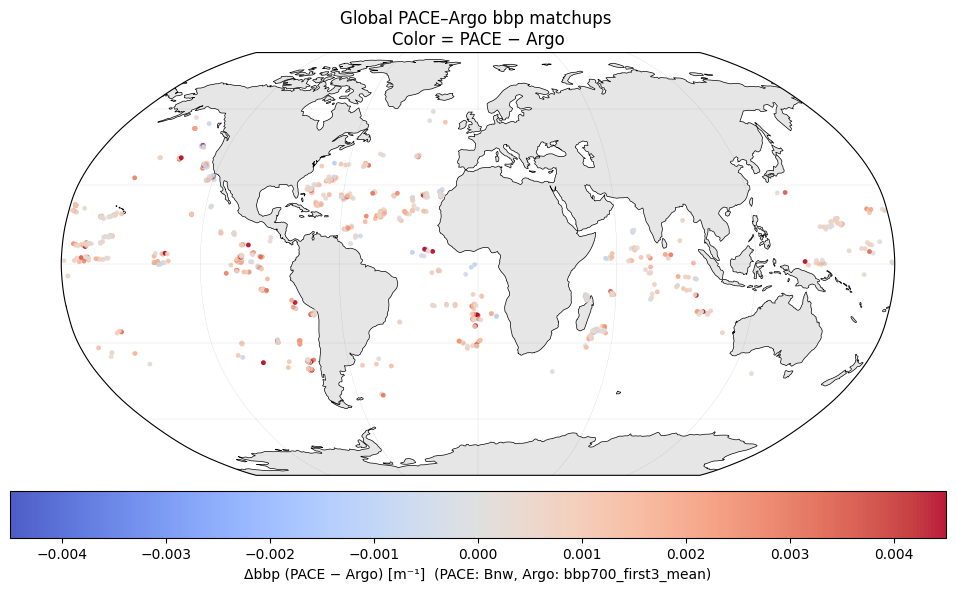

In [14]:
from pathlib import Path
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# -------- paths (edit if needed) --------
ROOT = Path.home() / "Documents" / "summer 2025" / "python" / "bing" / "papers" / "biomass" / "Analysis"
CSV_MATCHED = ROOT / "matched_argo_bgc_profiles_bbp.csv"          # PACE 'Bnw' + cruise/profile + lat/lon
CSV_ARGO    = ROOT / "bbp_first3_by_float_profile.csv"            # NEW Argo file (has bbp700_first3_mean)

# -------- load & normalize column names --------
m = pd.read_csv(CSV_MATCHED)
a = pd.read_csv(CSV_ARGO)
m.columns = [re.sub(r"\s+","_", c.strip().lower()) for c in m.columns]
a.columns = [re.sub(r"\s+","_", c.strip().lower()) for c in a.columns]

# --- explicit PACE column ---
PACE_BBP_COL = "bnw"   # PACE bbp column in matched CSV (lower-case after normalization)
if PACE_BBP_COL not in m.columns:
    raise KeyError(f"'{PACE_BBP_COL}' not found in matched CSV. Got: {m.columns.tolist()}")

# --- required keys & subset helpful columns ---
if not {"cruise","profile","lat","lon"}.issubset(m.columns):
    raise KeyError("Matched CSV must have 'cruise','profile','lat','lon'.")
if not {"wmo","profile","bbp700_first3_mean"}.issubset(a.columns):
    raise KeyError("Argo CSV must have 'wmo','profile','bbp700_first3_mean'.")

# Prepare PACE table (rename cruise/profile to numeric types)
m2 = m[["cruise","profile", PACE_BBP_COL, "lat","lon"]].copy()
m2["cruise"]  = pd.to_numeric(m2["cruise"], errors="coerce").astype("Int64")
m2["profile"] = pd.to_numeric(m2["profile"], errors="coerce").astype("Int64")

# Prepare Argo table (first-3 mean bbp700)
a2 = a[["wmo","profile","bbp700_first3_mean"]].copy()
a2["wmo"]     = pd.to_numeric(a2["wmo"], errors="coerce").astype("Int64")
a2["profile"] = pd.to_numeric(a2["profile"], errors="coerce").astype("Int64")

# --- join on WMO + profile (cycle) ---
mm = (m2.rename(columns={"cruise":"wmo"})  # now keys are wmo + profile on both sides
         .merge(a2, on=["wmo","profile"], how="inner", suffixes=("_pace","_argo")))

if mm.empty:
    raise ValueError("Merge produced 0 rows. Check that WMO/profile agree between files.")

# --- coordinates: use PACE lat/lon ---
lat = pd.to_numeric(mm["lat"], errors="coerce")
lon = pd.to_numeric(mm["lon"], errors="coerce")

# --- bbp values ---
pace_bbp = pd.to_numeric(mm[PACE_BBP_COL], errors="coerce")             # PACE Bnw
argo_bbp = pd.to_numeric(mm["bbp700_first3_mean"], errors="coerce")     # Argo first-3 mean

mm = (mm.assign(_lat=lat, _lon=lon, delta_bbp=pace_bbp - argo_bbp)
        .dropna(subset=["_lat","_lon","delta_bbp"])
        .reset_index(drop=True))

# Wrap lon to [-180,180]
mm["_lon"] = ((mm["_lon"] + 180) % 360) - 180
delta = mm["delta_bbp"].to_numpy()

# Robust symmetric color limit around 0
p = np.nanpercentile(delta, [2.5, 97.5])
L = float(max(abs(p[0]), abs(p[1])))
if not np.isfinite(L) or L == 0:
    L = float(np.nanmax(np.abs(delta))) or 1e-6

print(f"Plottable matchups: {len(mm)}   Δbbp color range: ±{L:.3e} (PACE − Argo)")

# --- save merged table for later use ---
OUT_MERGED = ROOT / "matched_with_argo_bbp_delta_first3.csv"
(mm[["wmo","profile","_lat","_lon", PACE_BBP_COL,"bbp700_first3_mean","delta_bbp"]]
 .rename(columns={"_lat":"lat","_lon":"lon"})
 .to_csv(OUT_MERGED, index=False))
print(f"Saved merged table → {OUT_MERGED}")

# --- plot ---
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.add_feature(cfeature.LAND, facecolor="0.9", edgecolor="none", zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    ax.gridlines(draw_labels=False, linewidth=0.2, color="gray", alpha=0.4)

    sc = ax.scatter(mm["_lon"], mm["_lat"], c=mm["delta_bbp"], s=12,
                    cmap="coolwarm", vmin=-L, vmax=L,
                    transform=ccrs.PlateCarree(), linewidths=0, alpha=0.9)

    cb = plt.colorbar(sc, orientation="horizontal", pad=0.03, shrink=0.8)
    cb.set_label("Δbbp (PACE − Argo) [m⁻¹]  (PACE: Bnw, Argo: bbp700_first3_mean)")

    ax.set_title("Global PACE–Argo bbp matchups \nColor = PACE − Argo", fontsize=12)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Cartopy plot failed ({e}); using simple lon/lat scatter instead.")
    plt.figure(figsize=(10,5))
    plt.scatter(mm["_lon"], mm["_lat"], c=mm["delta_bbp"], s=12,
                cmap="coolwarm", vmin=-L, vmax=L)
    plt.colorbar(label="Δbbp (PACE − Argo) [m⁻¹]")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.title("PACE–Argo bbp matchups")
    plt.tight_layout()
    plt.show()

##### from pathlib import Path
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# -------- paths (edit if needed) --------
ROOT = Path.home() / "Documents" / "summer 2025" / "python" / "bing" / "papers" / "biomass" / "Analysis"
CSV_MATCHED = ROOT / "matched_argo_bgc_profiles_bbp.csv"          # PACE 'Bnw' + cruise/profile + lat/lon
CSV_ARGO    = ROOT / "bbp_first3_by_float_profile.csv"            # Argo first-3 mean bbp

# -------- load & normalize column names --------
m = pd.read_csv(CSV_MATCHED)
a = pd.read_csv(CSV_ARGO)
m.columns = [re.sub(r"\s+","_", c.strip().lower()) for c in m.columns]
a.columns = [re.sub(r"\s+","_", c.strip().lower()) for c in a.columns]

# --- explicit PACE column ---
PACE_BBP_COL = "bnw"   # PACE bbp column (lower-case after normalization)
if PACE_BBP_COL not in m.columns:
    raise KeyError(f"'{PACE_BBP_COL}' not found in matched CSV. Got: {m.columns.tolist()}")

# --- required keys & subset helpful columns ---
if not {"cruise","profile","lat","lon"}.issubset(m.columns):
    raise KeyError("Matched CSV must have 'cruise','profile','lat','lon'.")
if not {"wmo","profile","bbp700_first3_mean"}.issubset(a.columns):
    raise KeyError("Argo CSV must have 'wmo','profile','bbp700_first3_mean'.")

# Prepare PACE table (rename cruise/profile to numeric types)
m2 = m[["cruise","profile", PACE_BBP_COL, "lat","lon"]].copy()
m2["cruise"]  = pd.to_numeric(m2["cruise"], errors="coerce").astype("Int64")
m2["profile"] = pd.to_numeric(m2["profile"], errors="coerce").astype("Int64")

# Prepare Argo table (first-3 mean bbp700)
a2 = a[["wmo","profile","bbp700_first3_mean"]].copy()
a2["wmo"]     = pd.to_numeric(a2["wmo"], errors="coerce").astype("Int64")
a2["profile"] = pd.to_numeric(a2["profile"], errors="coerce").astype("Int64")

# --- join on WMO + profile (cycle) ---
mm = (m2.rename(columns={"cruise":"wmo"})  # now keys are wmo + profile on both sides
         .merge(a2, on=["wmo","profile"], how="inner", suffixes=("_pace","_argo")))
if mm.empty:
    raise ValueError("Merge produced 0 rows. Check that WMO/profile agree between files.")

# --- coordinates & values ---
lat = pd.to_numeric(mm["lat"], errors="coerce")
lon = pd.to_numeric(mm["lon"], errors="coerce")
pace_bbp = pd.to_numeric(mm[PACE_BBP_COL], errors="coerce")             # PACE Bnw
argo_bbp = pd.to_numeric(mm["bbp700_first3_mean"], errors="coerce")     # Argo first-3 mean

# Avoid divide-by-zero / negative PACE (bbp should be >0, but be safe)
valid = (lat.notna() & lon.notna() &
         pace_bbp.notna() & argo_bbp.notna() &
         (pace_bbp > 0))
mm = mm.loc[valid].copy()

mm["_lat"] = lat.loc[valid].values
mm["_lon"] = lon.loc[valid].values
mm["rel_dbbp"] = (pace_bbp.loc[valid] - argo_bbp.loc[valid]) / pace_bbp.loc[valid]

# Wrap lon to [-180,180] and clip to keep colorbar readable
mm["_lon"] = ((mm["_lon"] + 180) % 360) - 180
mm["rel_dbbp"] = mm["rel_dbbp"].clip(-1, 1)

print(f"Plottable matchups: {len(mm)}   Relative Δbbp range (clipped): [{mm['rel_dbbp'].min():.2f}, {mm['rel_dbbp'].max():.2f}]")

# --- save merged table for later use ---
OUT_MERGED = ROOT / "matched_with_argo_bbp_relpace_first3.csv"
(mm[["wmo","profile","_lat","_lon", PACE_BBP_COL,"bbp700_first3_mean","rel_dbbp"]]
 .rename(columns={"_lat":"lat","_lon":"lon"})
 .to_csv(OUT_MERGED, index=False))
print(f"Saved merged table → {OUT_MERGED}")

# --- plot ---
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.add_feature(cfeature.LAND, facecolor="0.9", edgecolor="none", zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    ax.gridlines(draw_labels=False, linewidth=0.2, color="gray", alpha=0.4)

    sc = ax.scatter(mm["_lon"], mm["_lat"], c=mm["rel_dbbp"], s=12,
                    cmap="RdBu_r", vmin=-1, vmax=1,
                    transform=ccrs.PlateCarree(), linewidths=0, alpha=0.9)

    cb = plt.colorbar(sc, orientation="horizontal", pad=0.03, shrink=0.8)
    cb.set_label("Relative Δbbp = (PACE − Argo) / PACE (unitless)")

    ax.set_title("Global PACE–Argo bbp matchups \nColor = (PACE − Argo) / PACE", fontsize=12)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Cartopy plot failed ({e}); using simple lon/lat scatter instead.")
    plt.figure(figsize=(10,5))
    plt.scatter(mm["_lon"], mm["_lat"], c=mm["rel_dbbp"], s=12,
                cmap="RdBu_r", vmin=-1, vmax=1)
    plt.colorbar(label="Relative Δbbp = (PACE − Argo) / PACE")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.title("PACE–Argo bbp matchups")
    plt.tight_layout()
    plt.show()

Plottable matchups: 811   Relative Δbbp range (clipped): [-1.00, 1.00]
Saved merged table → /Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_with_argo_bbp_relpace_first3.csv


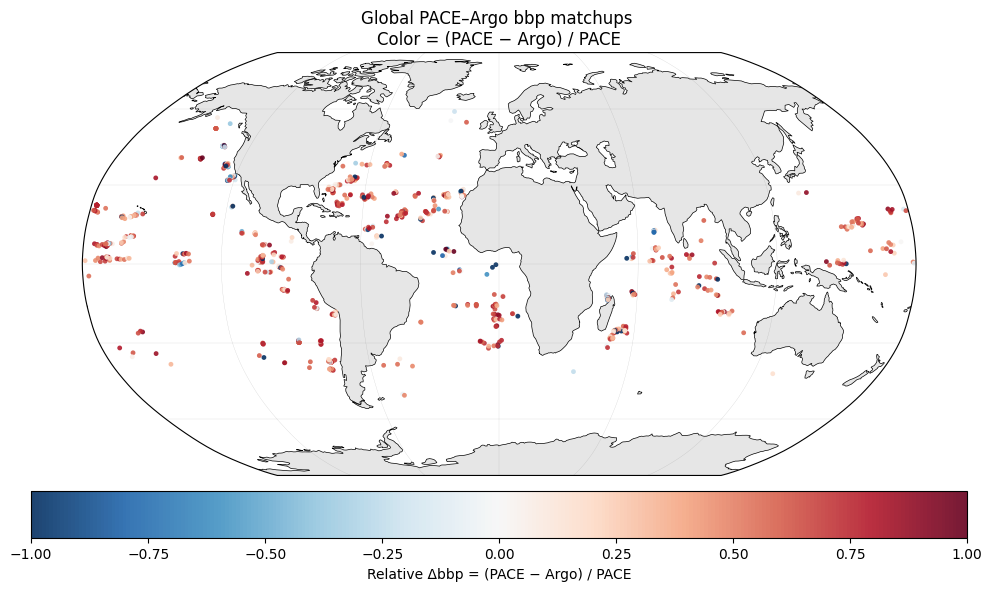

In [20]:
from pathlib import Path
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# -------- paths (edit if needed) --------
ROOT = Path.home() / "Documents" / "summer 2025" / "python" / "bing" / "papers" / "biomass" / "Analysis"
CSV_MATCHED = ROOT / "matched_argo_bgc_profiles_bbp.csv"          # PACE 'Bnw' + cruise/profile + lat/lon
CSV_ARGO    = ROOT / "bbp_first3_by_float_profile.csv"            # Argo first-3 mean bbp

# -------- load & normalize column names --------
m = pd.read_csv(CSV_MATCHED)
a = pd.read_csv(CSV_ARGO)
m.columns = [re.sub(r"\s+","_", c.strip().lower()) for c in m.columns]
a.columns = [re.sub(r"\s+","_", c.strip().lower()) for c in a.columns]

# --- explicit PACE column ---
PACE_BBP_COL = "bnw"   # PACE bbp column (lower-case after normalization)
if PACE_BBP_COL not in m.columns:
    raise KeyError(f"'{PACE_BBP_COL}' not found in matched CSV. Got: {m.columns.tolist()}")

# --- required keys & subset helpful columns ---
if not {"cruise","profile","lat","lon"}.issubset(m.columns):
    raise KeyError("Matched CSV must have 'cruise','profile','lat','lon'.")
if not {"wmo","profile","bbp700_first3_mean"}.issubset(a.columns):
    raise KeyError("Argo CSV must have 'wmo','profile','bbp700_first3_mean'.")

# Prepare PACE table (rename cruise/profile to numeric types)
m2 = m[["cruise","profile", PACE_BBP_COL, "lat","lon"]].copy()
m2["cruise"]  = pd.to_numeric(m2["cruise"], errors="coerce").astype("Int64")
m2["profile"] = pd.to_numeric(m2["profile"], errors="coerce").astype("Int64")

# Prepare Argo table (first-3 mean bbp700)
a2 = a[["wmo","profile","bbp700_first3_mean"]].copy()
a2["wmo"]     = pd.to_numeric(a2["wmo"], errors="coerce").astype("Int64")
a2["profile"] = pd.to_numeric(a2["profile"], errors="coerce").astype("Int64")

# --- join on WMO + profile (cycle) ---
mm = (m2.rename(columns={"cruise":"wmo"})  # now keys are wmo + profile on both sides
         .merge(a2, on=["wmo","profile"], how="inner", suffixes=("_pace","_argo")))
if mm.empty:
    raise ValueError("Merge produced 0 rows. Check that WMO/profile agree between files.")

# --- coordinates & values ---
lat = pd.to_numeric(mm["lat"], errors="coerce")
lon = pd.to_numeric(mm["lon"], errors="coerce")
pace_bbp = pd.to_numeric(mm[PACE_BBP_COL], errors="coerce")             # PACE Bnw
argo_bbp = pd.to_numeric(mm["bbp700_first3_mean"], errors="coerce")     # Argo first-3 mean

# Avoid divide-by-zero / negative PACE (bbp should be >0, but be safe)
valid = (lat.notna() & lon.notna() &
         pace_bbp.notna() & argo_bbp.notna() &
         (pace_bbp > 0))
mm = mm.loc[valid].copy()

mm["_lat"] = lat.loc[valid].values
mm["_lon"] = lon.loc[valid].values
mm["rel_dbbp"] = (pace_bbp.loc[valid] - argo_bbp.loc[valid]) / pace_bbp.loc[valid]

# Wrap lon to [-180,180] and clip to keep colorbar readable
mm["_lon"] = ((mm["_lon"] + 180) % 360) - 180
mm["rel_dbbp"] = mm["rel_dbbp"].clip(-1, 1)

print(f"Plottable matchups: {len(mm)}   Relative Δbbp range (clipped): [{mm['rel_dbbp'].min():.2f}, {mm['rel_dbbp'].max():.2f}]")

# --- save merged table for later use ---
OUT_MERGED = ROOT / "matched_with_argo_bbp_relpace_first3.csv"
(mm[["wmo","profile","_lat","_lon", PACE_BBP_COL,"bbp700_first3_mean","rel_dbbp"]]
 .rename(columns={"_lat":"lat","_lon":"lon"})
 .to_csv(OUT_MERGED, index=False))
print(f"Saved merged table → {OUT_MERGED}")

# --- plot ---
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.add_feature(cfeature.LAND, facecolor="0.9", edgecolor="none", zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    ax.gridlines(draw_labels=False, linewidth=0.2, color="gray", alpha=0.4)

    sc = ax.scatter(mm["_lon"], mm["_lat"], c=mm["rel_dbbp"], s=12,
                    cmap="RdBu_r", vmin=-1, vmax=1,
                    transform=ccrs.PlateCarree(), linewidths=0, alpha=0.9)

    cb = plt.colorbar(sc, orientation="horizontal", pad=0.03, shrink=0.8)
    cb.set_label("Relative Δbbp = (PACE − Argo) / PACE")

    ax.set_title("Global PACE–Argo bbp matchups \nColor = (PACE − Argo) / PACE", fontsize=12)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Cartopy plot failed ({e}); using simple lon/lat scatter instead.")
    plt.figure(figsize=(10,5))
    plt.scatter(mm["_lon"], mm["_lat"], c=mm["rel_dbbp"], s=12,
                cmap="RdBu_r", vmin=-1, vmax=1)
    plt.colorbar(label="Relative Δbbp = (PACE − Argo) / PACE")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.title("PACE–Argo bbp matchups")
    plt.tight_layout()
    plt.show()

In [28]:
from pathlib import Path
import pandas as pd
import numpy as np

# --------- locate files (CSV or XLSX) ----------
def find_one(patterns):
    home = Path.home()
    hits = []
    for pat in patterns:
        hits += list(home.rglob(pat))
    if not hits: return None
    hits = sorted(set(hits), key=lambda p: p.stat().st_mtime, reverse=True)
    return hits[0]

f3_path = find_one([
    "bbp_first3_by_float_profile*.csv", "bbp_first3_by_float_profile*.xlsx",
    "*first3*bbp*.csv", "*first3*bbp*.xlsx"
])
mm_path = find_one([
    "matched_argo_bgc_profiles_bbp*.csv", "matched_argo_bgc_profiles_bbp*.xlsx",
    "*matched*argo*bgc*bbp*.csv", "*matched*argo*bgc*bbp*.xlsx"
])

if f3_path is None or mm_path is None:
    raise FileNotFoundError("Couldn’t find one or both files. If they’re .numbers, export to CSV first.")

print("Using:")
print("  first3:", f3_path)
print("  matched:", mm_path)

# --------- read CSV/XLSX ----------
def read_any(p: Path):
    return pd.read_excel(p) if p.suffix.lower()==".xlsx" else pd.read_csv(p)
f3 = read_any(f3_path)
mm = read_any(mm_path)

# --------- helpers to guess key columns ----------
def _is_intlike(s):
    s = pd.to_numeric(s, errors="coerce")
    n = s.notna().sum()
    return n / max(len(s),1) > 0.8, s  # mostly numeric

def guess_wmo_col(df):
    cols = list(df.columns)
    # priority names
    for name in ["wmo","platform_number","platformnumber","platform_id","argo_platform","argo_id","platform"]:
        for c in cols:
            if c.lower()==name: return c
    # heuristic: 6–8 digit integers (typical WMO)
    best = None
    for c in cols:
        ok, s = _is_intlike(df[c])
        if not ok: continue
        vals = s.dropna().astype(float)
        frac_wmo = ((vals>=1e5) & (vals<1e8)).mean()  # allow 5–8 digits
        if frac_wmo>0.8:
            best = c; break
    return best

def guess_cycle_col(df):
    for name in ["cycle","cycle_number","profilenumber","profile_number","profile","cycle_no"]:
        for c in df.columns:
            if c.lower()==name: return c
    # heuristic: small non-negative ints (0..400)
    best = None
    for c in df.columns:
        ok, s = _is_intlike(df[c])
        if not ok: continue
        vals = s.dropna().astype(float)
        frac_cycle = ((vals>=0) & (vals<=400) & (vals%1==0)).mean()
        if frac_cycle>0.8:
            best = c; break
    return best

def find_first3_col(df):
    # look for bbp + first3-ish
    for c in df.columns:
        cl = c.lower()
        if "bbp" in cl and any(tag in cl for tag in ["first3","first_3","mean3","surface_mean3","firstthree"]):
            return c
    # fallback: if only one bbp-like col, use it
    bbp_like = [c for c in df.columns if "bbp" in c.lower()]
    if len(bbp_like)==1: return bbp_like[0]
    return None

# --------- detect keys/columns ----------
wmo_f3   = guess_wmo_col(f3)
wmo_mm   = guess_wmo_col(mm)
cycle_f3 = guess_cycle_col(f3)
cycle_mm = guess_cycle_col(mm)
bbp_col  = find_first3_col(f3)

print("\nDetected columns:")
print("  f3  wmo:", wmo_f3, " | cycle:", cycle_f3, " | first3 col:", bbp_col)
print("  mm  wmo:", wmo_mm, " | cycle:", cycle_mm)

if wmo_f3 is None or wmo_mm is None:
    raise KeyError("Could not detect the float ID column in one/both files. "
                   "Please rename the float ID column to 'wmo' or 'platform_number'.")

# unify names
f3 = f3.rename(columns={wmo_f3:"wmo"})
mm = mm.rename(columns={wmo_mm:"wmo"})
join_keys = ["wmo"]

if cycle_f3 and cycle_mm:
    f3 = f3.rename(columns={cycle_f3:"cycle"})
    mm = mm.rename(columns={cycle_mm:"cycle"})
    join_keys = ["wmo","cycle"]

if bbp_col is None:
    raise KeyError("Couldn't find a 'first-3' bbp column in the first3 file "
                   "(look for names like 'bbp_first3_mean' or 'bbp700_surface_mean3').")

# --------- merge ----------
f3_slim = f3[join_keys + [bbp_col]].drop_duplicates()
merged = mm.merge(f3_slim, on=join_keys, how="left").rename(columns={bbp_col:"bbp_first3_mean"})

out = Path.cwd() / "matched_with_first3_added.csv"
merged.to_csv(out, index=False)

print("\n✅ Merge complete")
print("Join keys used:", join_keys)
print("Rows total:", len(merged))
print("Rows with bbp_first3_mean filled:", merged["bbp_first3_mean"].notna().sum())
print("Saved →", out)

Using:
  first3: /Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/bbp_first3_by_float_profile.csv
  matched: /Users/allie/Downloads/matched_argo_bgc_profiles_bbp.csv

Detected columns:
  f3  wmo: wmo  | cycle: profile  | first3 col: bbp700_first3_mean
  mm  wmo: cruise  | cycle: profile

✅ Merge complete
Join keys used: ['wmo', 'cycle']
Rows total: 812
Rows with bbp_first3_mean filled: 812
Saved → /Users/allie/matched_with_first3_added.csv


In [29]:
from pathlib import Path

ANALYSIS = Path.home() / "Documents" / "summer 2025" / "python" / "bing" / "papers" / "biomass" / "Analysis"
ANALYSIS.mkdir(parents=True, exist_ok=True)

OUT = ANALYSIS / "matched_with_first3_added.csv"
merged.to_csv(OUT, index=False)
print("Saved →", OUT)

Saved → /Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_with_first3_added.csv


Saved: /Users/allie/delta_over_time.csv  (rows=686)
Mean δ = -2.636, Median δ = 0.524


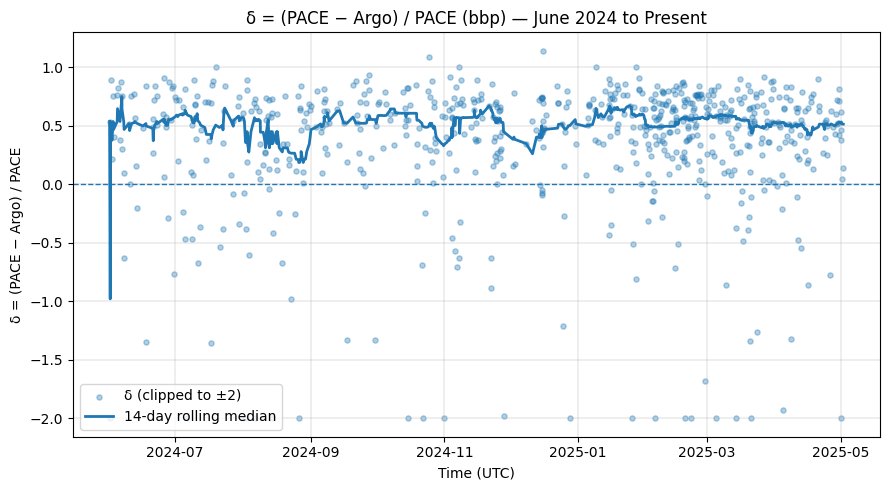

Figure saved: /Users/allie/delta_over_time.png


In [31]:
# === δ over time from 'matched_with_first3_added.csv' ===
# Columns: PACE = Bnw, ARGO = bbp_first3_mean
# Works in Anaconda Navigator / Jupyter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.dates import DateFormatter, AutoDateLocator

# ---------------- user settings ----------------
CSV_PATH = Path("matched_with_first3_added.csv")  # change if stored elsewhere
TIME_COL_CANDIDATES = ["profile_time", "_time", "time", "datetime", "timestamp", "time_start"]
START_DATE = pd.Timestamp("2024-06-01", tz="UTC")
END_DATE = pd.Timestamp.utcnow()
ROLL_DAYS = 14
OUT_CSV = Path("delta_over_time.csv")
OUT_PNG = Path("delta_over_time.png")
TITLE = r"δ = (PACE − Argo) / PACE (bbp) — June 2024 to Present"
PACE_COL = "Bnw"
ARGO_COL = "bbp_first3_mean"
# ------------------------------------------------

def pick_time_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
        # case-insensitive fallback
        for col in df.columns:
            if col.lower() == c.lower():
                return col
    # last resort: try something that looks like time
    for col in df.columns:
        if any(tok in col.lower() for tok in ["time", "date", "datetime", "timestamp"]):
            return col
    return None

# Load
df = pd.read_csv(CSV_PATH)

# Parse time
tcol = pick_time_col(df, TIME_COL_CANDIDATES)
if tcol is None:
    raise KeyError(
        f"Couldn't find a time column. Try adding one of {TIME_COL_CANDIDATES} "
        f"or set TIME_COL_CANDIDATES to match your file.\nColumns: {list(df.columns)}"
    )
df[tcol] = pd.to_datetime(df[tcol], errors="coerce", utc=True)
df = df.dropna(subset=[tcol])

# Numeric PACE/ARGO
PACE = pd.to_numeric(df[PACE_COL], errors="coerce")
ARGO = pd.to_numeric(df[ARGO_COL], errors="coerce")

# δ = (PACE - ARGO)/PACE
delta = (PACE - ARGO) / PACE

# Validity filter: finite δ and PACE>0
valid = np.isfinite(delta) & (PACE > 0)
dfv = df.loc[valid, [tcol]].copy()
dfv["delta"] = delta[valid].values

# Date filter: June 1, 2024 → now (UTC)
dfv = dfv[(dfv[tcol] >= START_DATE) & (dfv[tcol] <= END_DATE)]
if dfv.empty:
    raise ValueError("No valid rows after computing δ and date filtering. "
                     "Check time parsing or column names.")

# Sort & rolling median
dfv = dfv.sort_values(tcol)
roll = dfv.set_index(tcol)["delta"].rolling(f"{ROLL_DAYS}D").median()

# Save tidy CSV
out = dfv.rename(columns={tcol: "time_utc"})[["time_utc", "delta"]]
out.to_csv(OUT_CSV, index=False)
print(f"Saved: {OUT_CSV.resolve()}  (rows={len(out)})")
print(f"Mean δ = {out['delta'].mean():.3f}, Median δ = {out['delta'].median():.3f}")

# Plot
plt.figure(figsize=(9,5))
# clip extremes for visibility on the scatter (CSV stays un-clipped)
yclip = dfv["delta"].clip(-2, 2)
plt.scatter(dfv[tcol], yclip, s=14, alpha=0.35, label="δ (clipped to ±2)")
plt.plot(roll.index, roll.values, linewidth=2, label=f"{ROLL_DAYS}-day rolling median")
plt.axhline(0, ls="--", lw=1)

plt.title(TITLE)
plt.ylabel("δ = (PACE − Argo) / PACE")
plt.xlabel("Time (UTC)")
ax = plt.gca()
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.grid(True, lw=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200)
plt.show()
print(f"Figure saved: {OUT_PNG.resolve()}")

Saved: /Users/allie/delta_over_time_unclipped.csv (rows=686)
Mean δ=-2.636, Median δ=0.524, Min δ=-369.680, Max δ=1.141


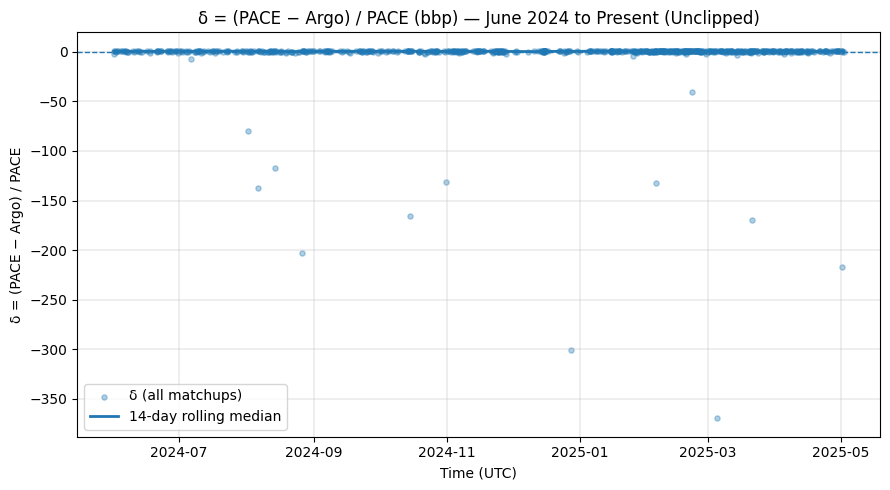

Figure saved: /Users/allie/delta_over_time_unclipped.png


In [33]:
# === Unclipped δ over time (PACE = Bnw, Argo = bbp_first3_mean) ===
# δ = (PACE - Argo) / PACE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.dates import DateFormatter, AutoDateLocator

# ---- settings ----
CSV_PATH = Path("matched_with_first3_added.csv")
TIME_COL_CANDIDATES = ["profile_time", "_time", "time", "datetime", "timestamp", "time_start"]
PACE_COL = "Bnw"
ARGO_COL = "bbp_first3_mean"
START_DATE = pd.Timestamp("2024-06-01", tz="UTC")
END_DATE = pd.Timestamp.utcnow()
ROLL_DAYS = 14
OUT_CSV = Path("delta_over_time_unclipped.csv")
OUT_PNG = Path("delta_over_time_unclipped.png")
TITLE = r"δ = (PACE − Argo) / PACE (bbp) — June 2024 to Present (Unclipped)"
# -------------------

def pick_time_col(df, candidates):
    for c in candidates:
        if c in df.columns: return c
        for col in df.columns:
            if col.lower() == c.lower(): return col
    for col in df.columns:
        if any(tok in col.lower() for tok in ["time", "date", "datetime", "timestamp"]):
            return col
    return None

# Load & parse time
df = pd.read_csv(CSV_PATH)
tcol = pick_time_col(df, TIME_COL_CANDIDATES)
if tcol is None:
    raise KeyError(f"Need a time column (tried {TIME_COL_CANDIDATES}). Got: {list(df.columns)}")
df[tcol] = pd.to_datetime(df[tcol], errors="coerce", utc=True)
df = df.dropna(subset=[tcol])

# Compute δ
PACE = pd.to_numeric(df[PACE_COL], errors="coerce")
ARGO = pd.to_numeric(df[ARGO_COL], errors="coerce")
delta = (PACE - ARGO) / PACE

valid = np.isfinite(delta) & (PACE > 0)
dfv = df.loc[valid, [tcol]].copy()
dfv["delta"] = delta[valid].values

# Date filter
dfv = dfv[(dfv[tcol] >= START_DATE) & (dfv[tcol] <= END_DATE)]
dfv = dfv.sort_values(tcol)
if dfv.empty:
    raise ValueError("No rows after filtering; check time parsing and column names.")

# Rolling median (uses full, *unclipped* data)
roll = dfv.set_index(tcol)["delta"].rolling(f"{ROLL_DAYS}D").median()

# Save tidy output
out = dfv.rename(columns={tcol: "time_utc"})[["time_utc", "delta"]]
out.to_csv(OUT_CSV, index=False)
print(f"Saved: {OUT_CSV.resolve()} (rows={len(out)})")
print(f"Mean δ={out['delta'].mean():.3f}, Median δ={out['delta'].median():.3f}, "
      f"Min δ={out['delta'].min():.3f}, Max δ={out['delta'].max():.3f}")

# Plot (no clipping)
plt.figure(figsize=(9,5))
plt.scatter(dfv[tcol], dfv["delta"], s=14, alpha=0.35, label="δ (all matchups)")
plt.plot(roll.index, roll.values, linewidth=2, label=f"{ROLL_DAYS}-day rolling median")
plt.axhline(0, ls="--", lw=1)

plt.title(TITLE)
plt.ylabel("δ = (PACE − Argo) / PACE")
plt.xlabel("Time (UTC)")
ax = plt.gca()
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.grid(True, lw=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200)
plt.show()
print(f"Figure saved: {OUT_PNG.resolve()}")

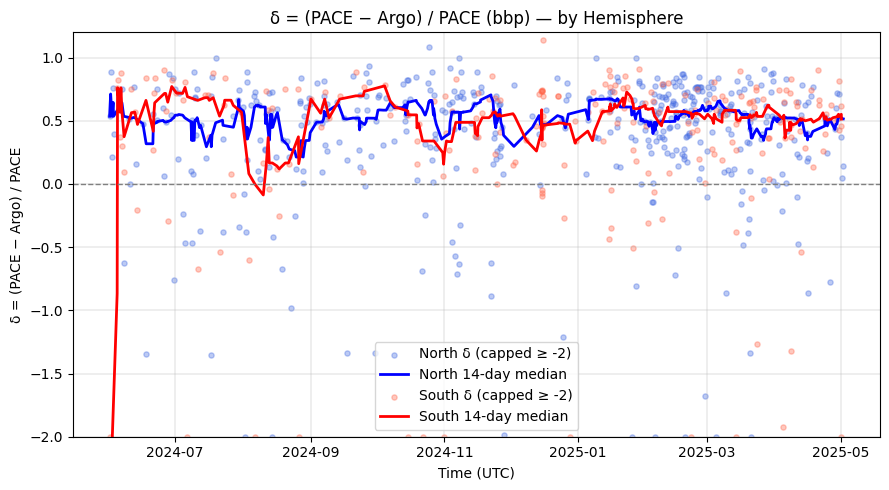

Saved figure → /Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/delta_over_time_by_hemisphere_capm2.png


In [48]:
# === δ over time by hemisphere (scatter floored at −2), saved to Analysis ===
# δ = (PACE − Argo) / PACE  |  PACE = Bnw, Argo = bbp_first3_mean

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.dates import DateFormatter, AutoDateLocator

# -------- paths & settings --------
CSV_PATH = Path("matched_with_first3_added.csv")  # change if your CSV lives elsewhere
OUT_PNG = Path("/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/delta_over_time_by_hemisphere_capm2.png")

PACE_COL, ARGO_COL = "Bnw", "bbp_first3_mean"
LAT_COLS = ["_lat", "lat", "latitude"]
TIME_COLS = ["profile_time", "_time", "time", "datetime", "timestamp", "time_start"]
START_DATE = pd.Timestamp("2024-06-01", tz="UTC")
ROLL_DAYS = 14

# -------- helpers --------
def pick(df, cands):
    for c in cands:
        if c in df.columns:
            return c
        for col in df.columns:
            if col.lower() == c.lower():
                return col
    raise KeyError(f"Need one of {cands}; have {list(df.columns)}")

# -------- load & compute δ --------
df = pd.read_csv(CSV_PATH)
tcol = pick(df, TIME_COLS)
latcol = pick(df, LAT_COLS)

df[tcol] = pd.to_datetime(df[tcol], errors="coerce", utc=True)
df = df.dropna(subset=[tcol, latcol])

PACE = pd.to_numeric(df[PACE_COL], errors="coerce")
ARGO = pd.to_numeric(df[ARGO_COL], errors="coerce")
df["delta"] = (PACE - ARGO) / PACE

# validity: finite δ and sensible PACE>0
df = df[np.isfinite(df["delta"]) & (PACE > 0)]
df = df[df[tcol] >= START_DATE].sort_values(tcol)

# split by hemisphere
north = df[df[latcol] >= 0].copy()
south = df[df[latcol] < 0].copy()

# rolling medians (UNcapped)
roll_n = north.set_index(tcol)["delta"].rolling(f"{ROLL_DAYS}D").median()
roll_s = south.set_index(tcol)["delta"].rolling(f"{ROLL_DAYS}D").median()

# ---- Plot: cap only the scatter at -2 for readability ----
fig, ax = plt.subplots(figsize=(9,5))

north_cap = np.maximum(north["delta"].values, -2.0)
south_cap = np.maximum(south["delta"].values, -2.0)

ax.scatter(north[tcol], north_cap, s=14, alpha=0.35, color="royalblue", label="North δ (capped ≥ -2)")
ax.plot(roll_n.index, roll_n.values, color="blue", lw=2, label=f"North {ROLL_DAYS}-day median")

ax.scatter(south[tcol], south_cap, s=14, alpha=0.35, color="tomato", label="South δ (capped ≥ -2)")
ax.plot(roll_s.index, roll_s.values, color="red", lw=2, label=f"South {ROLL_DAYS}-day median")

ax.axhline(0, ls="--", lw=1, color="gray")
ax.set_title(r"δ = (PACE − Argo) / PACE (bbp) — by Hemisphere")
ax.set_ylabel("δ = (PACE − Argo) / PACE")
ax.set_xlabel("Time (UTC)")
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
ax.grid(True, lw=0.3)
ax.legend()

# y-limits: floor at -2, auto upper bound with a little headroom
upper = max(df["delta"].quantile(0.99), 1.2)
ax.set_ylim(-2, upper)

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200)
plt.show()
print(f"Saved figure → {OUT_PNG.resolve()}")


Strict matchups (<50 km & <3 h): 68


/var/folders/54/5kc2y0693j37p_j3_04pyxkc0000gn/T/ipykernel_99958/3122923176.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 0.95])
/opt/anaconda3/envs/earthaccess-env/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


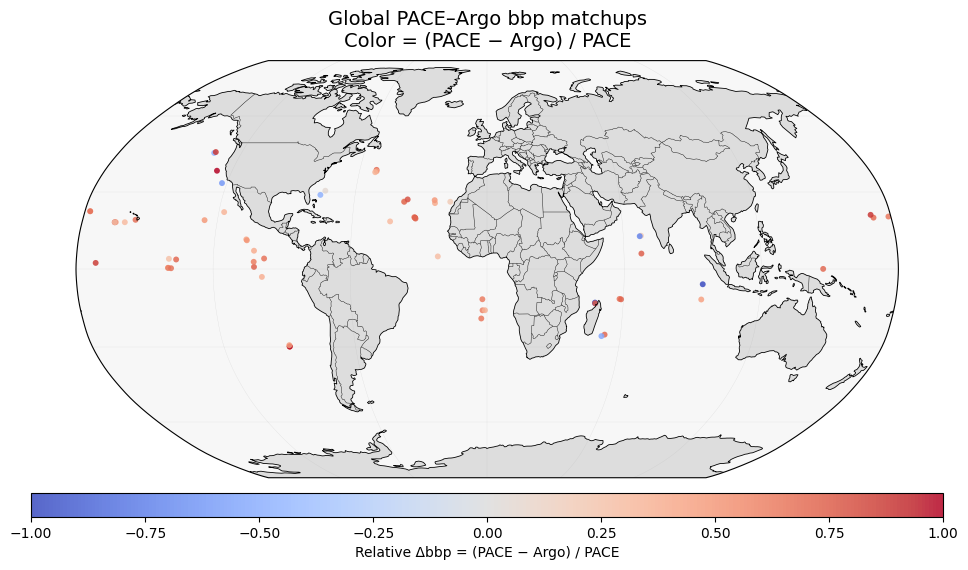

Saved figure → /Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/global_map_strict_style.png


In [43]:
# === Global PACE–Argo bbp matchups (STRICT ONLY) ===
# Style matches your screenshot: Robinson projection + large horizontal colorbar
# δ = (PACE − Argo) / PACE, color range [-1, 1]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# cartopy (install if needed: conda install -c conda-forge cartopy)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ---- paths & columns ----
CSV_PATH = Path("matched_with_first3_added.csv")
OUT_PNG  = Path("/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/global_map_strict_style.png")

PACE_COL   = "Bnw"                 # PACE bbp
ARGO_COL   = "bbp_first3_mean"     # Argo surface bbp
LAT_COL    = "lat"
LON_COL    = "lon"
DIST_COL   = "closest_dist_km"     # km
ARGO_TIME  = "time"                # Argo timestamp (UTC)
PACE_TIME  = "closest_time"        # PACE timestamp (UTC)

STRICT_DIST_KM = 50
STRICT_TDIFF_H = 3
VMIN, VMAX = -1.0, 1.0

# ---- load & prep ----
df = pd.read_csv(CSV_PATH)

# parse times and compute |Δt| (hours)
df[ARGO_TIME] = pd.to_datetime(df[ARGO_TIME], errors="coerce", utc=True)
df[PACE_TIME] = pd.to_datetime(df[PACE_TIME], errors="coerce", utc=True)
df["time_diff_hr"] = (df[ARGO_TIME] - df[PACE_TIME]).abs().dt.total_seconds() / 3600.0

# numerics
for col in [PACE_COL, ARGO_COL, LAT_COL, LON_COL, DIST_COL, "time_diff_hr"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# δ = (PACE − Argo)/PACE
df["delta"] = (df[PACE_COL] - df[ARGO_COL]) / df[PACE_COL]

# validity + STRICT filters
valid = (
    np.isfinite(df["delta"]) &
    (df[PACE_COL] > 0) &
    np.isfinite(df[LAT_COL]) & np.isfinite(df[LON_COL]) &
    np.isfinite(df[DIST_COL]) & np.isfinite(df["time_diff_hr"])
)
strict = df.loc[
    valid & (df[DIST_COL] < STRICT_DIST_KM) & (df["time_diff_hr"] < STRICT_TDIFF_H)
].copy()

print(f"Strict matchups (<{STRICT_DIST_KM} km & <{STRICT_TDIFF_H} h): {len(strict)}")

# ---- plot (Robinson) ----
proj_map = ccrs.Robinson()
proj_data = ccrs.PlateCarree()

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=proj_map)
ax.set_global()

# background & features to match your style
ax.add_feature(cfeature.LAND.with_scale("110m"), facecolor="#dddddd")
ax.add_feature(cfeature.OCEAN.with_scale("110m"), facecolor="#f7f7f7")
ax.coastlines(linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.gridlines(draw_labels=False, linewidth=0.2, alpha=0.4)

# scatter (consistent color scale; data not clipped, only color saturates at [-1,1])
sc = ax.scatter(
    strict[LON_COL], strict[LAT_COL],
    c=strict["delta"], s=18, alpha=0.85, transform=proj_data,
    cmap="coolwarm", vmin=VMIN, vmax=VMAX, edgecolor="none"
)

# titles like your example
plt.title("Global PACE–Argo bbp matchups\nColor = (PACE − Argo) / PACE", fontsize=14, pad=10)

# big horizontal colorbar below
cax = fig.add_axes([0.12, 0.08, 0.76, 0.04])  # [left, bottom, width, height]
cb = plt.colorbar(sc, cax=cax, orientation="horizontal")
cb.set_label("Relative Δbbp = (PACE − Argo) / PACE")

plt.tight_layout(rect=[0, 0.12, 1, 0.95])
plt.savefig(OUT_PNG, dpi=200)
plt.show()
print(f"Saved figure → {OUT_PNG.resolve()}")

In [45]:
print(f"Total valid PACE–Argo matchups: {len(df)}")


Total valid PACE–Argo matchups: 811


Total valid PACE–Argo matchups: 811


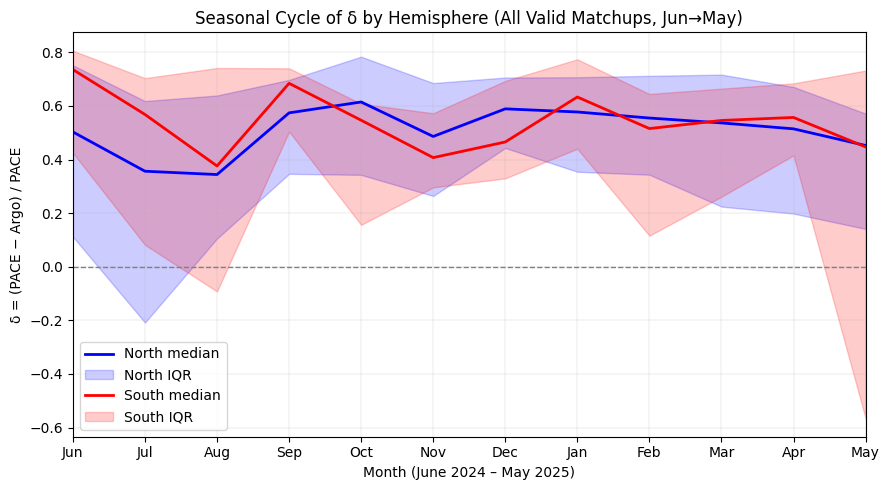

Saved → /Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/seasonal_delta_by_month_all_junemay.png

Counts per month (all matchups, Jun→May):
hemi   North  South
month              
Jun       19     10
Jul       19     13
Aug       32     12
Sep       26      8
Oct       22      9
Nov       29     18
Dec        9     27
Jan       35     31
Feb      108     26
Mar       68     36
Apr       60     44
May       29     10


In [47]:
# === Seasonal δ by month (ALL matchups, June→May ordering) ===
# δ = (PACE − Argo) / PACE, medians with IQR by hemisphere
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH = Path("matched_with_first3_added.csv")
OUT_PNG  = Path("/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/seasonal_delta_by_month_all_junemay.png")

PACE_COL, ARGO_COL = "Bnw", "bbp_first3_mean"
LAT_COL, LON_COL   = "lat", "lon"
ARGO_TIME, PACE_TIME = "time", "closest_time"

# Load
df = pd.read_csv(CSV_PATH)
df[ARGO_TIME] = pd.to_datetime(df[ARGO_TIME], errors="coerce", utc=True)
df[PACE_TIME] = pd.to_datetime(df[PACE_TIME], errors="coerce", utc=True)
for col in [PACE_COL, ARGO_COL, LAT_COL, LON_COL]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# δ
df["delta"] = (df[PACE_COL] - df[ARGO_COL]) / df[PACE_COL]

# Valid rows
valid = np.isfinite(df["delta"]) & np.isfinite(df[LAT_COL]) & np.isfinite(df[LON_COL]) & (df[PACE_COL] > 0)
df = df.loc[valid].copy()
print(f"Total valid PACE–Argo matchups: {len(df)}")

# Month + hemisphere
df["month"] = df[PACE_TIME].dt.month
df["hemi"]  = np.where(df[LAT_COL] >= 0, "North", "South")

# Monthly stats per hemisphere
g = (df.groupby(["hemi","month"])["delta"]
       .agg(median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75))
       .reset_index())

# Reorder months: June → May
month_order  = [6,7,8,9,10,11,12,1,2,3,4,5]
month_labels = ['Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']
order_idx = pd.Index(month_order, name="month")

def reindex_hemi(sub):
    sub = sub.set_index("month").reindex(order_idx).reset_index()
    return sub

gN = reindex_hemi(g[g["hemi"]=="North"].drop(columns="hemi")).assign(hemi="North")
gS = reindex_hemi(g[g["hemi"]=="South"].drop(columns="hemi")).assign(hemi="South")
g  = pd.concat([gN, gS], ignore_index=True)

# Plot
fig, ax = plt.subplots(figsize=(9,5))
for hemi, color in [("North","blue"), ("South","red")]:
    gg = g[g["hemi"]==hemi]
    ax.plot(range(1,13), gg["median"], lw=2, color=color, label=f"{hemi} median")
    ax.fill_between(range(1,13), gg["q25"], gg["q75"], color=color, alpha=0.20, label=f"{hemi} IQR")

ax.axhline(0, ls="--", color="gray", lw=1)
ax.set_xlim(1,12)
ax.set_xticks(range(1,13))
ax.set_xticklabels(month_labels)
ax.set_xlabel("Month (June 2024 – May 2025)")
ax.set_ylabel("δ = (PACE − Argo) / PACE")
ax.set_title("Seasonal Cycle of δ by Hemisphere (All Valid Matchups, Jun→May)")
ax.grid(True, lw=0.3, alpha=0.6)
ax.legend()

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200)
plt.show()
print(f"Saved → {OUT_PNG.resolve()}")

# Optional: coverage table in Jun→May order
counts = df.groupby(["hemi","month"]).size().unstack(0, fill_value=0).reindex(month_order)
print("\nCounts per month (all matchups, Jun→May):")
print(counts.rename(index=dict(zip(month_order, month_labels))))

In [54]:
CSV = "/Users/<you>/Desktop/matched_with_first3_added.csv"  # or your iCloud path


In [56]:
from pathlib import Path
import pandas as pd
import numpy as np

# --- 1) Locate the CSV in your Analysis folder (and iCloud, just in case) ---
possible_roots = [
    Path.home() / "Documents/summer 2025/python/bing/papers/biomass/Analysis",
    Path.home() / "Documents/Analysis",
    Path.home() / "Library/Mobile Documents/com~apple~CloudDocs",  # iCloud Drive root
]

# Look for likely filenames
hits = []
for root in possible_roots:
    if root.exists():
        hits += list(root.rglob("*matched*first3*added*.csv"))

print("Found candidates:")
for i, p in enumerate(hits):
    print(f"[{i}] {p}")

# Pick the one you want (edit index if needed)
CSV = str(hits[0])  # change to the correct index if multiple are printed
print("Using:", CSV)

# --- 2) Load & continue with your verification code ---
df = pd.read_csv(CSV)
print(df.head())

Found candidates:
[0] /Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_with_first3_added.csv
Using: /Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_with_first3_added.csv
       wmo      filename  cycle     lat      lon  \
0  1902368  1902368QC.nc     13  56.348 -147.356   
1  1902369  1902369QC.nc      4  45.006 -133.357   
2  1902369  1902369QC.nc      5  45.020 -133.356   
3  1902369  1902369QC.nc      6  45.020 -133.354   
4  1902369  1902369QC.nc      7  45.038 -133.348   

                                  time  solar_angle  \
0  2024-07-09 04:35:00.000002048+00:00    13.134825   
1  2024-05-09 22:07:00.000001536+00:00    58.276589   
2  2024-05-10 09:02:59.999999488+00:00   -27.116450   
3  2024-05-10 19:52:59.999998464+00:00    60.421381   
4  2024-05-11 08:18:59.999995904+00:00   -26.535430   

                                            pace_ids  \
0  PACE_OCI_L2_AOP_PACE_OCI.20240708T202028.L2.OC...   
1  PACE_OCI_L

       wmo      filename    lat                                 time      lon      Bnw  bbp_first3_mean     delta
0  1902368  1902368QC.nc 56.348  2024-07-09 04:35:00.000002048+00:00 -147.356 0.001467         0.001345  0.082661
1  1902369  1902369QC.nc 45.006  2024-05-09 22:07:00.000001536+00:00 -133.357 0.000501         0.000713 -0.422998
2  1902369  1902369QC.nc 45.020  2024-05-10 09:02:59.999999488+00:00 -133.356 0.000475         0.000683 -0.438885
3  1902369  1902369QC.nc 45.020  2024-05-10 19:52:59.999998464+00:00 -133.354 0.000475         0.000705 -0.485935
4  1902369  1902369QC.nc 45.038  2024-05-11 08:18:59.999995904+00:00 -133.348 0.000603         0.000692 -0.148538
5  1902369  1902369QC.nc 45.367  2024-08-02 19:35:00.000002048+00:00 -132.841 0.008180         0.000911  0.888626
6  1902369  1902369QC.nc 45.161  2024-08-23 03:24:00.000004608+00:00 -132.562 0.003336         0.006601 -0.978458
7  1902369  1902369QC.nc 44.734  2024-10-12 21:48:59.999995904+00:00 -131.990 0.004153  

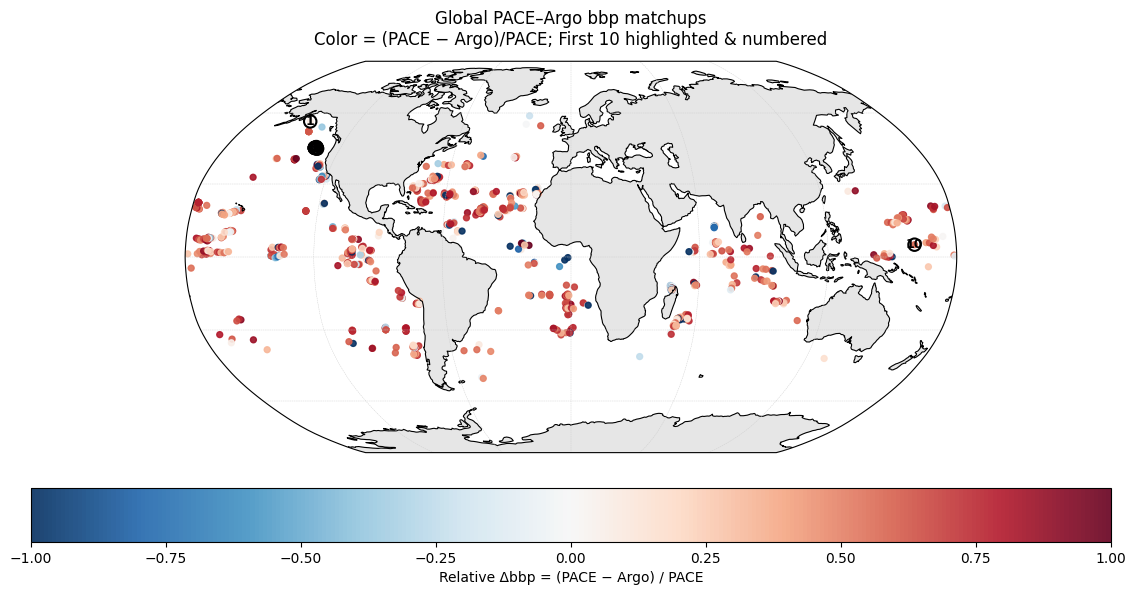

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize

# --- load your merged table ---
CSV = "/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_with_first3_added.csv"
df = pd.read_csv(CSV)

# --- column picks (adjust if yours differ) ---
lat = 'lat'
lon = 'lon'
pace = 'Bnw'                        # PACE bbp at ~700 nm
argo = 'bbp_first3_mean'            # Argo bbp (mean of first 3 depths)
time_col = 'time' if 'time' in df.columns else None

# --- compute δ and clip for color scale ---
df['delta'] = (df[pace] - df[argo]) / df[pace]
df['delta_clip'] = df['delta'].clip(-1, 1)

# --- base map like before ---
proj = ccrs.Robinson()
fig = plt.figure(figsize=(13, 6))
ax = plt.axes(projection=proj)
ax.set_global()
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='0.9', edgecolor='none')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.gridlines(draw_labels=False, linewidth=0.3, color='0.8', linestyle='--')

# all matchups
sc = ax.scatter(df[lon].values, df[lat].values,
                c=df['delta_clip'].values, s=18,
                cmap='RdBu_r', norm=Normalize(-1, 1),
                transform=ccrs.PlateCarree(), alpha=0.9)

# colorbar
cb = plt.colorbar(sc, orientation='horizontal', pad=0.07, shrink=0.85)
cb.set_label("Relative Δbbp = (PACE − Argo) / PACE")

# --- highlight the first 10 rows ---
first10 = df.iloc[:10].copy()
ax.scatter(first10[lon], first10[lat],
           s=80, facecolor='none', edgecolor='k', linewidth=1.5,
           transform=ccrs.PlateCarree(), zorder=5)

# number them 1..10 next to the markers
for i, (_, r) in enumerate(first10.iterrows(), start=1):
    ax.text(r[lon], r[lat], str(i),
            transform=ccrs.PlateCarree(),
            fontsize=9, fontweight='bold',
            ha='center', va='center', color='k', zorder=6)

plt.title("Global PACE–Argo bbp matchups\nColor = (PACE − Argo)/PACE; First 10 highlighted & numbered", pad=12)
plt.tight_layout()

# --- print a quick cross-check table for the first 10 ---
cols_to_show = ['wmo', 'filename', lat, lon, pace, argo, 'delta']
if time_col: cols_to_show.insert(3, time_col)
print(first10[cols_to_show].to_string(index=lambda x: str(x+1)))  # 1-based display

Saved → /Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/first10_matchups_map_clean.png


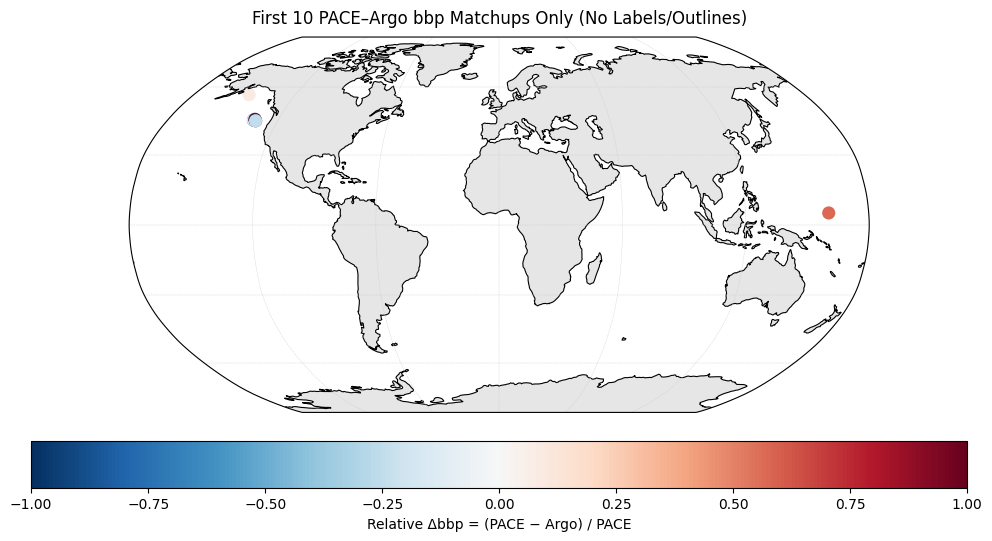

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature
from matplotlib.colors import Normalize
from pathlib import Path

# Paths
CSV = "/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/matched_with_first3_added.csv"
OUT = Path("/Users/allie/Documents/summer 2025/python/bing/papers/biomass/Analysis/first10_matchups_map_clean.png")

# Load + compute δ
df = pd.read_csv(CSV)
lat, lon   = "lat", "lon"
pace_col   = "Bnw"                   # PACE bbp (~700 nm)
argo_col   = "bbp_first3_mean"       # If yours is bbp700_first3_mean, change this line

df["delta"] = (df[pace_col] - df[argo_col]) / df[pace_col]
first10 = df.iloc[:10].copy()
first10["delta_clip"] = first10["delta"].clip(-1, 1)

# Plot (no outlines, no labels)
proj = ccrs.Robinson()
fig = plt.figure(figsize=(12, 5.5))
ax = plt.axes(projection=proj)
ax.set_global()
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor="0.9", edgecolor="none")
ax.add_feature(cfeature.OCEAN, facecolor="white")
ax.gridlines(draw_labels=False, linewidth=0.3, color="0.8", linestyle="--")

sc = ax.scatter(
    first10[lon], first10[lat],
    c=first10["delta_clip"], s=90,
    cmap="RdBu_r", norm=Normalize(-1, 1),
    transform=ccrs.PlateCarree(),
    linewidth=0  # no outlines
)

cb = plt.colorbar(sc, orientation="horizontal", pad=0.06, shrink=0.8)
cb.set_label("Relative Δbbp = (PACE − Argo) / PACE")

plt.title("First 10 PACE–Argo bbp Matchups Only (No Labels/Outlines)", pad=10)
plt.tight_layout()
plt.savefig(OUT, dpi=300)
print(f"Saved → {OUT}")